# ECG Image-to-Signal Training — Final Optimized

**Best architecture selected from all previous experiments**, optimized for **speed + accuracy**.

### Why this is the best approach:
| Optimization | Detail |
|---|---|
| **Architecture** | Hybrid CNN (ResNet18) + Lightweight Transformer + Conv1d Decoder |
| **Parameters** | ~10M (20× fewer than V1's 210M) |
| **Temporal Projection** | Conv1d upsampling (not dense layer) — faster & better generalization |
| **LR Scheduler** | OneCycleLR — converges in fewer epochs than CosineAnnealing |
| **Mixed Precision** | FP16 via `torch.cuda.amp` — 2× faster on GPU |
| **Data Loading** | `persistent_workers` + `pin_memory` + `prefetch_factor` |
| **Augmentation** | Robust 7-transform pipeline for generalization |
| **Early Stopping** | Patience-based with best-model checkpointing |
| **Gradient Clipping** | Max norm 1.0 for training stability |

In [1]:
# Cell 1: Imports & Environment Check
import os, time, random, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from ecg_image_to_signal_trainer import (
    ECGImageSignalDataset,
    CompositeLoss,
    compute_pearson_correlation,
    compute_r_peak_error,
    plot_comparison,
)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

PyTorch: 2.6.0+cu124
CUDA: True
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory: 6.4 GB
Using: cuda


## 1. Configuration — Tuned for Speed + Quality

In [2]:
# Cell 2: All hyperparameters in one place
CONFIG = {
    # Data
    'dataset_root': 'output',
    'image_size': (224, 448),   # ← FIX: preserve 4:1 aspect ratio (images are 1968x472)
    'signal_length': 1000,      # actual signals are 1000 samples

    # Training
    'batch_size': 16,           # ← smaller batch = noisier gradients → helps escape trivial soln
    'num_epochs': 80,
    'max_lr': 3e-4,             # ← conservative; differential LR will boost decoder separately
    'weight_decay': 1e-4,       # ← lighter regularization
    'grad_clip': 1.0,

    # Loss weights (SmoothL1 primary, Pearson secondary)
    'l1_weight': 1.0,
    'mse_weight': 0.5,
    'pearson_weight': 0.3,
    'derivative_weight': 0.1,
    'pearson_warmup_epochs': 3,

    # Efficiency
    'num_workers': 4,
    'prefetch_factor': 2,
    'pin_memory': torch.cuda.is_available(),

    # Checkpointing
    'checkpoint_dir': 'checkpoints_final',
    'patience': 20,
    'device': device,
}

print("=" * 60)
print("FIXED CONFIGURATION — aspect ratio + no augmentation")
print("=" * 60)
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

FIXED CONFIGURATION — aspect ratio + no augmentation
  dataset_root: output
  image_size: (224, 448)
  signal_length: 1000
  batch_size: 16
  num_epochs: 80
  max_lr: 0.0003
  weight_decay: 0.0001
  grad_clip: 1.0
  l1_weight: 1.0
  mse_weight: 0.5
  pearson_weight: 0.3
  derivative_weight: 0.1
  pearson_warmup_epochs: 3
  num_workers: 4
  prefetch_factor: 2
  pin_memory: True
  checkpoint_dir: checkpoints_final
  patience: 20
  device: cuda


## 2. Model Architecture — Efficient Hybrid CNN + Transformer

**Pipeline**: ResNet18 → 49 Spatial Tokens → 2-Layer Transformer → Direct Temporal Upsampling → 1D CNN Decoder

**Key fix**: Removed the linear bottleneck (49×256 → 4 timesteps) that was destroying temporal information. Now uses 49 tokens directly as temporal positions → interpolate to 64 → Conv1d decode to 5000.

In [3]:
# Cell 3: Model building blocks + full model

class ResidualConvBlock(nn.Module):
    """Residual 1D transposed conv block — GroupNorm to avoid BatchNorm collapse."""
    def __init__(self, in_ch, out_ch, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.ConvTranspose1d(in_ch, out_ch, kernel_size, stride, padding)
        # FIX: GroupNorm instead of BatchNorm — BN collapses when output is near-constant
        num_groups = min(8, out_ch)
        self.norm = nn.GroupNorm(num_groups, out_ch)
        self.act = nn.ELU(inplace=True)
        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        if isinstance(self.skip, nn.Conv1d):
            s = F.interpolate(x, scale_factor=2, mode='linear', align_corners=False)
            s = self.skip(s)
        else:
            s = F.interpolate(x, scale_factor=2, mode='linear', align_corners=False)
        return self.act(self.norm(self.conv(x)) + s)


class LightweightTransformerBlock(nn.Module):
    """Efficient self-attention block (Pre-LN, 4 heads, GELU MLP)."""
    def __init__(self, dim, heads=4, mlp_ratio=2.0, drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        h = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, h), nn.GELU(), nn.Dropout(drop),
            nn.Linear(h, dim), nn.Dropout(drop),
        )

    def forward(self, x):
        xn = self.norm1(x)
        x = x + self.attn(xn, xn, xn)[0]
        x = x + self.mlp(self.norm2(x))
        return x


class ECGImageToSignalModelV3(nn.Module):
    """
    FIXED Hybrid CNN + Transformer for ECG image → 1000-sample signal.

    KEY FIXES:
    1. Dynamic positional embeddings — works with any image aspect ratio
    2. GroupNorm in decoder instead of BatchNorm (prevents collapse)
    3. Larger decoder capacity with proper skip connections
    4. Head initialized to output non-trivial values
    """
    def __init__(self, signal_length=1000, pretrained=True, image_size=(224, 448)):
        super().__init__()
        self.signal_length = signal_length
        D = 256

        # Backbone: ResNet18 without avgpool/fc
        resnet = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        # Only freeze stem conv + bn
        for n, p in self.backbone.named_parameters():
            if n.startswith('0.') or n.startswith('1.'):
                p.requires_grad = False

        # Compute expected spatial tokens for the given image size
        h_tokens = image_size[0] // 32  # ResNet18 downsamples by 32
        w_tokens = image_size[1] // 32
        num_tokens = h_tokens * w_tokens
        print(f"  Spatial tokens: {h_tokens}x{w_tokens} = {num_tokens}")

        # Spatial token projection + LEARNABLE positional encoding
        self.proj = nn.Linear(512, D)
        self.pos_emb = nn.Parameter(torch.randn(1, num_tokens, D) * 0.02)
        self._num_tokens = num_tokens

        # Transformer bridge (2 lightweight blocks)
        self.transformer = nn.ModuleList([
            LightweightTransformerBlock(D, heads=4, mlp_ratio=2.0) for _ in range(2)
        ])
        self.norm = nn.LayerNorm(D)

        # Channel reduction before temporal upsampling
        self.channel_reduce = nn.Sequential(
            nn.Conv1d(D, 128, kernel_size=3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ELU(inplace=True),
        )

        # Temporal decoder: 64 → 128 → 256 → 512 → 1024  (4 doublings)
        self.decoder = nn.Sequential(
            ResidualConvBlock(128, 64),    # → 128
            ResidualConvBlock(64, 32),     # → 256
            nn.Dropout(0.05),
            ResidualConvBlock(32, 16),     # → 512
            ResidualConvBlock(16, 8),      # → 1024
        )

        # Output head
        self.head = nn.Sequential(
            nn.Conv1d(8, 8, kernel_size=5, padding=2),
            nn.ELU(inplace=True),
            nn.Conv1d(8, 1, kernel_size=7, padding=3),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.decoder.modules():
            if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
        # Initialize head to output values with std ≈ 1
        for m in self.head.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_normal_(m.weight, gain=1.0)  # gain=1.0, not 0.5
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.size(0)
        f = self.backbone(x)                          # (B, 512, H', W')
        H, W = f.shape[2], f.shape[3]
        num_tokens = H * W
        f = f.flatten(2).permute(0, 2, 1)             # (B, num_tokens, 512)
        f = self.proj(f)                              # (B, num_tokens, 256)

        # Dynamic positional embedding: interpolate if token count doesn't match
        if num_tokens != self._num_tokens:
            pos = F.interpolate(
                self.pos_emb.permute(0, 2, 1),
                size=num_tokens, mode='linear', align_corners=False
            ).permute(0, 2, 1)
        else:
            pos = self.pos_emb
        f = f + pos

        for blk in self.transformer:
            f = blk(f)
        f = self.norm(f)                              # (B, num_tokens, 256)

        # Temporal rearrangement
        f = f.permute(0, 2, 1)                        # (B, 256, num_tokens)
        f = F.interpolate(f, size=64, mode='linear', align_corners=False)
        f = self.channel_reduce(f)                    # (B, 128, 64)

        s = self.decoder(f)                           # (B, 8, 1024)
        s = self.head(s).squeeze(1)                   # (B, 1024)

        # Interpolate to match signal_length
        if s.size(-1) != self.signal_length:
            s = F.interpolate(s.unsqueeze(1), size=self.signal_length,
                              mode='linear', align_corners=False).squeeze(1)
        return s

# Quick check
_m = ECGImageToSignalModelV3(signal_length=1000, pretrained=False, image_size=CONFIG['image_size'])
_total = sum(p.numel() for p in _m.parameters())
_train = sum(p.numel() for p in _m.parameters() if p.requires_grad)
print(f"Model — Total params: {_total:,}  |  Trainable: {_train:,}")

with torch.no_grad():
    _h, _w = CONFIG['image_size']
    _x = torch.randn(2, 3, _h, _w)
    _y = _m(_x)
    print(f"Output shape: {_y.shape}  |  mean={_y.mean():.3f}  |  std={_y.std():.3f}")
del _m

  Spatial tokens: 7x14 = 98
Model — Total params: 12,541,601  |  Trainable: 12,532,065
Output shape: torch.Size([2, 1000])  |  mean=-2.244  |  std=1.728


## 3. Dataset Preparation

In [4]:
# Cell 4: Dataset split + DataLoaders — NO AUGMENTATION (model must learn basics first)

image_dir = os.path.join(CONFIG['dataset_root'], 'images')
signal_dir = os.path.join(CONFIG['dataset_root'], 'signals')

all_samples = ECGImageSignalDataset._find_samples(image_dir, signal_dir)
random.seed(42)
random.shuffle(all_samples)

split = int(0.8 * len(all_samples))
train_samples, val_samples = all_samples[:split], all_samples[split:]
print(f"Total: {len(all_samples)} | Train: {len(train_samples)} | Val: {len(val_samples)}")

# CLEAN transforms — NO augmentation until the model can learn basic reconstruction
base_tf = transforms.Compose([
    transforms.Resize(CONFIG['image_size']),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# FIX: Use clean transforms for BOTH train and val
# Augmentation was destroying the learning signal — 8 transforms at once!
train_ds = ECGImageSignalDataset(
    image_dir, signal_dir, CONFIG['image_size'], CONFIG['signal_length'],
    transform=base_tf, augment=False, cache_data=False, samples=train_samples,
)

val_ds = ECGImageSignalDataset(
    image_dir, signal_dir, CONFIG['image_size'], CONFIG['signal_length'],
    transform=base_tf, augment=False, samples=val_samples,
)

# DataLoaders
nw = CONFIG['num_workers']
train_loader = DataLoader(
    train_ds, batch_size=CONFIG['batch_size'], shuffle=True,
    num_workers=nw, pin_memory=CONFIG['pin_memory'],
    persistent_workers=nw > 0, prefetch_factor=CONFIG['prefetch_factor'] if nw > 0 else None,
)
val_loader = DataLoader(
    val_ds, batch_size=CONFIG['batch_size'] * 2, shuffle=False,
    num_workers=nw, pin_memory=CONFIG['pin_memory'],
    persistent_workers=nw > 0, prefetch_factor=CONFIG['prefetch_factor'] if nw > 0 else None,
)

# Quick data sanity check
sample_img, sample_sig = train_ds[0]
print(f"Image shape: {sample_img.shape} | Signal shape: {sample_sig.shape}")
print(f"Signal stats: mean={sample_sig.mean():.4f}, std={sample_sig.std():.4f}, min={sample_sig.min():.4f}, max={sample_sig.max():.4f}")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")
print(f"NO augmentation — clean data for learning basic reconstruction")

Total: 21799 | Train: 17439 | Val: 4360
Dataset initialized with 17439 samples
Dataset initialized with 4360 samples
Image shape: torch.Size([3, 224, 448]) | Signal shape: torch.Size([1000])
Signal stats: mean=0.0000, std=1.0005, min=-1.6257, max=6.3512
Train batches: 1090 | Val batches: 137
NO augmentation — clean data for learning basic reconstruction


## 4. Training Engine

Key speed optimizations over previous versions:
- **OneCycleLR** — super-convergence in ~60 epochs (vs 100+ with CosineAnnealing)
- **Larger val batch** (2× train) since no gradients needed
- **Epoch timing** for monitoring throughput

In [5]:
# Cell 5: FIXED Loss + Trainer — SmoothL1 primary loss + gradient diagnostics

class StableLossWithWarmup(nn.Module):
    """
    FIXED composite loss:
    1. SmoothL1 (Huber) as PRIMARY loss — constant gradient for large errors,
       prevents getting stuck at trivial solution (unlike MSE which has vanishing gradients near mean)
    2. MSE as secondary stabilizer
    3. Pearson + derivative with warmup (only after model shows learning signal)
    """
    def __init__(self, l1_weight=1.0, mse_weight=0.5, pearson_weight=0.3,
                 derivative_weight=0.1, warmup_epochs=3):
        super().__init__()
        self.l1_weight = l1_weight
        self.mse_weight = mse_weight
        self.pearson_weight = pearson_weight
        self.derivative_weight = derivative_weight
        self.warmup_epochs = warmup_epochs
        self._current_epoch = 0

    def set_epoch(self, epoch):
        self._current_epoch = epoch

    def forward(self, pred, target):
        pred_f = pred.float()
        target_f = target.float()

        # PRIMARY: SmoothL1 (Huber) — has constant gradient for large errors
        # This is the KEY fix: MSE gradient → 0 near the mean, but SmoothL1 grad = ±1
        smooth_l1 = F.smooth_l1_loss(pred_f, target_f, beta=1.0)

        # SECONDARY: MSE for fine-grained optimization once model is learning
        mse = F.mse_loss(pred_f, target_f)

        # Warmup factor for correlation-based losses
        epoch = self._current_epoch
        if epoch < self.warmup_epochs:
            warmup = 0.0
        else:
            warmup = min(1.0, (epoch - self.warmup_epochs) / 3.0)

        # Pearson loss (float32)
        pearson = self._stable_pearson_loss(pred_f, target_f)

        # Derivative loss (float32)
        derivative = self._derivative_loss(pred_f, target_f)

        total = (self.l1_weight * smooth_l1 +
                 self.mse_weight * mse +
                 warmup * self.pearson_weight * pearson +
                 warmup * self.derivative_weight * derivative)

        return total, {
            'smooth_l1': smooth_l1.item(),
            'mse': mse.item(),
            'pearson': pearson.item(),
            'derivative': derivative.item(),
            'warmup': warmup,
        }

    def _stable_pearson_loss(self, pred, target):
        pred_c = pred - pred.mean(dim=1, keepdim=True)
        target_c = target - target.mean(dim=1, keepdim=True)
        num = (pred_c * target_c).sum(dim=1)
        pred_var = (pred_c ** 2).sum(dim=1)
        target_var = (target_c ** 2).sum(dim=1)
        denom = torch.sqrt(torch.clamp(pred_var * target_var, min=1e-6))
        corr = torch.clamp(num / denom, -1.0, 1.0)
        return 1.0 - corr.mean()

    def _derivative_loss(self, pred, target):
        pred_d = pred[:, 1:] - pred[:, :-1]
        target_d = target[:, 1:] - target[:, :-1]
        return F.smooth_l1_loss(pred_d, target_d)


class ECGTrainerFinal:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,
                 scheduler, device, ckpt_dir='checkpoints_final', patience=20):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.ckpt_dir = ckpt_dir
        self.patience = patience
        self.scaler = GradScaler('cuda')
        os.makedirs(ckpt_dir, exist_ok=True)
        self.best_val_loss = float('inf')
        self.no_improve = 0
        self.history = {
            'train_loss': [], 'val_loss': [],
            'val_pearson': [], 'val_rpeak_err': [], 'lr': [], 'epoch_time': [],
        }

    def _train_one_epoch(self, epoch):
        self.model.train()
        self.criterion.set_epoch(epoch)
        total_loss = total_mse = total_l1 = 0
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch} [Train]', leave=False)
        for batch_idx, (imgs, sigs) in enumerate(pbar):
            imgs = imgs.to(self.device, non_blocking=True)
            sigs = sigs.to(self.device, non_blocking=True)
            self.optimizer.zero_grad(set_to_none=True)

            with autocast('cuda'):
                pred = self.model(imgs)

            # Loss in float32
            loss, ld = self.criterion(pred.float(), sigs.float())

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), CONFIG['grad_clip'])
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()

            total_loss += loss.item()
            total_mse += ld['mse']
            total_l1 += ld['smooth_l1']

            # Gradient diagnostics on first batch of first epoch
            if epoch == 1 and batch_idx == 0:
                grad_norms = {}
                for name, p in self.model.named_parameters():
                    if p.grad is not None:
                        grad_norms[name.split('.')[0]] = grad_norms.get(name.split('.')[0], 0) + p.grad.norm().item()
                print(f"\n  [Gradient diagnostics] Module grad norms:")
                for module, gnorm in sorted(grad_norms.items(), key=lambda x: -x[1]):
                    print(f"    {module}: {gnorm:.6f}")

                # Check prediction statistics
                with torch.no_grad():
                    print(f"  [Pred stats] mean={pred.mean():.4f}, std={pred.std():.4f}, "
                          f"min={pred.min():.4f}, max={pred.max():.4f}")
                    print(f"  [Target stats] mean={sigs.mean():.4f}, std={sigs.std():.4f}, "
                          f"min={sigs.min():.4f}, max={sigs.max():.4f}")

            pbar.set_postfix(loss=f"{loss.item():.4f}", l1=f"{ld['smooth_l1']:.4f}",
                           mse=f"{ld['mse']:.4f}", warmup=f"{ld['warmup']:.1f}")

        n = len(self.train_loader)
        return total_loss / n, total_mse / n, total_l1 / n

    @torch.no_grad()
    def _validate(self, epoch):
        self.model.eval()
        self.criterion.set_epoch(epoch)
        total_loss = total_mse = 0
        all_p, all_t = [], []
        pbar = tqdm(self.val_loader, desc=f'Epoch {epoch} [Val]', leave=False)
        for imgs, sigs in pbar:
            imgs = imgs.to(self.device, non_blocking=True)
            sigs = sigs.to(self.device, non_blocking=True)
            with autocast('cuda'):
                pred = self.model(imgs)
            loss, ld = self.criterion(pred.float(), sigs.float())
            total_loss += loss.item()
            total_mse += ld['mse']
            all_p.append(pred.float()); all_t.append(sigs.float())

        all_p, all_t = torch.cat(all_p), torch.cat(all_t)
        n = len(self.val_loader)
        pearson, _ = compute_pearson_correlation(all_p, all_t)
        rpeak = compute_r_peak_error(all_p, all_t)
        avg_loss = total_loss / n
        print(f"  [Val] Loss: {avg_loss:.4f} | MSE: {total_mse/n:.4f} | "
              f"Pearson: {pearson:.4f} | R-peak Err: {rpeak:.1f} ms | "
              f"Pred std: {all_p.std():.4f}")
        return avg_loss, pearson, rpeak, all_p, all_t

    def _save(self, epoch, val_loss, is_best=False):
        ckpt = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'history': self.history,
        }
        torch.save(ckpt, os.path.join(self.ckpt_dir, 'latest_checkpoint.pth'))
        if is_best:
            torch.save(ckpt, os.path.join(self.ckpt_dir, 'best_model.pth'))
            print(f"  >>> New BEST model saved (val_loss={val_loss:.4f})")

    def load_checkpoint(self, path):
        ckpt = torch.load(path, map_location=self.device, weights_only=False)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        if 'scheduler_state_dict' in ckpt:
            self.scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        self.history = ckpt.get('history', self.history)
        print(f"Resumed from epoch {ckpt['epoch']}")
        return ckpt['epoch']

    def train(self, num_epochs, resume_from=None):
        start_epoch = 0
        if resume_from and os.path.exists(resume_from):
            start_epoch = self.load_checkpoint(resume_from)

        print(f"\n{'='*60}")
        print(f"Training — {num_epochs} epochs | Device: {self.device}")
        print(f"Train: {len(self.train_loader.dataset)} | Val: {len(self.val_loader.dataset)}")
        print(f"Loss: SmoothL1 + MSE + Pearson (warmup={self.criterion.warmup_epochs})")
        print(f"{'='*60}")

        for epoch in range(start_epoch, num_epochs):
            t0 = time.time()
            lr = self.optimizer.param_groups[0]['lr']
            print(f"\nEpoch {epoch+1}/{num_epochs} | LR: {lr:.6f}")

            train_loss, _, _ = self._train_one_epoch(epoch + 1)
            val_loss, val_pear, val_rpeak, pred, tgt = self._validate(epoch + 1)

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_pearson'].append(val_pear)
            self.history['val_rpeak_err'].append(val_rpeak)
            self.history['lr'].append(lr)
            dt = time.time() - t0
            self.history['epoch_time'].append(dt)

            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
                self.no_improve = 0
            else:
                self.no_improve += 1
            self._save(epoch + 1, val_loss, is_best)

            print(f"  Train Loss: {train_loss:.4f} | Time: {dt:.0f}s | "
                  f"No improv: {self.no_improve}/{self.patience}")

            if (epoch + 1) % 10 == 0:
                p = os.path.join(self.ckpt_dir, f'epoch_{epoch+1}_comparison.png')
                plot_comparison(pred, tgt, num_samples=4, save_path=p)

            if self.no_improve >= self.patience:
                print(f"\n>>> Early stopping at epoch {epoch+1}")
                break

        total_time = sum(self.history['epoch_time'])
        print(f"\n{'='*60}")
        print(f"Done! Best val loss: {self.best_val_loss:.4f}")
        print(f"Total time: {total_time/60:.1f} min ({total_time/3600:.2f} h)")
        print(f"{'='*60}")
        return self.history

print("Trainer ready — SmoothL1 primary loss + gradient diagnostics")

Trainer ready — SmoothL1 primary loss + gradient diagnostics


## 5. Initialize & Train

In [6]:
# Cell 6: Model + Optimizer (DIFFERENTIAL LR) + Scheduler

model = ECGImageToSignalModelV3(
    signal_length=CONFIG['signal_length'],
    pretrained=True,
    image_size=CONFIG['image_size'],
)
model = model.to(CONFIG['device'])

total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params:     {total_p:,}")
print(f"Trainable params: {train_p:,}")

# Loss
criterion = StableLossWithWarmup(
    l1_weight=CONFIG['l1_weight'],
    mse_weight=CONFIG['mse_weight'],
    pearson_weight=CONFIG['pearson_weight'],
    derivative_weight=CONFIG['derivative_weight'],
    warmup_epochs=CONFIG['pearson_warmup_epochs'],
)

# DIFFERENTIAL LEARNING RATES:
# Backbone (pretrained) gets low LR — fine-tune gently
# Decoder + head (random init) gets HIGH LR — must learn from scratch
backbone_params = list(model.backbone.parameters())
other_params = [p for n, p in model.named_parameters()
                if not n.startswith('backbone') and p.requires_grad]

backbone_lr = CONFIG['max_lr'] * 0.1   # 10x lower for pretrained backbone
decoder_lr = CONFIG['max_lr'] * 3.0    # 3x higher for decoder (needs to escape trivial soln)

param_groups = [
    {'params': [p for p in backbone_params if p.requires_grad], 'lr': backbone_lr},
    {'params': other_params, 'lr': decoder_lr},
]

optimizer = torch.optim.AdamW(param_groups, weight_decay=CONFIG['weight_decay'])

# OneCycleLR with the decoder's (higher) learning rate
total_steps = CONFIG['num_epochs'] * len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[backbone_lr, decoder_lr],
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100,
)

print(f"\nOptimizer: AdamW — DIFFERENTIAL LR")
print(f"  Backbone LR: {backbone_lr:.6f}")
print(f"  Decoder  LR: {decoder_lr:.6f}")
print(f"Scheduler: OneCycleLR ({total_steps} steps)")
print(f"Loss: SmoothL1({CONFIG['l1_weight']}) + MSE({CONFIG['mse_weight']}) + "
      f"Pearson({CONFIG['pearson_weight']}) + Deriv({CONFIG['derivative_weight']})")
print(f"Pearson warmup: {CONFIG['pearson_warmup_epochs']} epochs")

  Spatial tokens: 7x14 = 98
Total params:     12,541,601
Trainable params: 12,532,065

Optimizer: AdamW — DIFFERENTIAL LR
  Backbone LR: 0.000030
  Decoder  LR: 0.000900
Scheduler: OneCycleLR (87200 steps)
Loss: SmoothL1(1.0) + MSE(0.5) + Pearson(0.3) + Deriv(0.1)
Pearson warmup: 3 epochs



Training — 80 epochs | Device: cuda
Train: 17439 | Val: 4360
Loss: SmoothL1 + MSE + Pearson (warmup=3)

Epoch 1/80 | LR: 0.000003


Epoch 1 [Train]:   0%|          | 2/1090 [00:22<2:46:31,  9.18s/it, l1=5.1142, loss=33.6421, mse=57.0559, warmup=0.0]


  [Gradient diagnostics] Module grad norms:
    pos_emb: 0.000000
    backbone: nan
    proj: nan
    transformer: nan
    norm: 0.000000
    channel_reduce: nan
    decoder: nan
    head: nan
  [Pred stats] mean=-3.9921, std=6.4771, min=-29.5617, max=4.4427
  [Target stats] mean=0.0000, std=1.0000, min=-6.3238, max=9.5323


  [Val] Loss: 0.7694 | MSE: 0.9693 | Pearson: 0.1547 | R-peak Err: 807.5 ms | Pred std: 0.1877
  >>> New BEST model saved (val_loss=0.7694)
  Train Loss: 1.0264 | Time: 165s | No improv: 0/20

Epoch 2/80 | LR: 0.000004


  [Val] Loss: 0.7519 | MSE: 0.9465 | Pearson: 0.2113 | R-peak Err: 556.2 ms | Pred std: 0.2326
  >>> New BEST model saved (val_loss=0.7519)
  Train Loss: 0.7638 | Time: 97s | No improv: 0/20

Epoch 3/80 | LR: 0.000007


  [Val] Loss: 0.6967 | MSE: 0.8812 | Pearson: 0.3309 | R-peak Err: 263.4 ms | Pred std: 0.3340
  >>> New BEST model saved (val_loss=0.6967)
  Train Loss: 0.7351 | Time: 94s | No improv: 0/20

Epoch 4/80 | LR: 0.000011


  [Val] Loss: 0.6169 | MSE: 0.7000 | Pearson: 0.5352 | R-peak Err: 148.7 ms | Pred std: 0.5742
  >>> New BEST model saved (val_loss=0.6169)
  Train Loss: 0.6856 | Time: 94s | No improv: 0/20

Epoch 5/80 | LR: 0.000017


  [Val] Loss: 0.5500 | MSE: 0.5724 | Pearson: 0.6439 | R-peak Err: 138.2 ms | Pred std: 0.6409
  >>> New BEST model saved (val_loss=0.5500)
  Train Loss: 0.6080 | Time: 95s | No improv: 0/20

Epoch 6/80 | LR: 0.000022


  [Val] Loss: 0.4571 | MSE: 0.4393 | Pearson: 0.7413 | R-peak Err: 134.9 ms | Pred std: 0.7848
  >>> New BEST model saved (val_loss=0.4571)
  Train Loss: 0.5399 | Time: 96s | No improv: 0/20

Epoch 7/80 | LR: 0.000026


  [Val] Loss: 0.3823 | MSE: 0.3623 | Pearson: 0.7940 | R-peak Err: 130.5 ms | Pred std: 0.8307
  >>> New BEST model saved (val_loss=0.3823)
  Train Loss: 0.4500 | Time: 95s | No improv: 0/20

Epoch 8/80 | LR: 0.000029


  [Val] Loss: 0.3172 | MSE: 0.2952 | Pearson: 0.8363 | R-peak Err: 134.1 ms | Pred std: 0.8539
  >>> New BEST model saved (val_loss=0.3172)
  Train Loss: 0.3744 | Time: 96s | No improv: 0/20

Epoch 9/80 | LR: 0.000030


  [Val] Loss: 0.3055 | MSE: 0.2881 | Pearson: 0.8420 | R-peak Err: 138.0 ms | Pred std: 0.8825
  >>> New BEST model saved (val_loss=0.3055)
  Train Loss: 0.3171 | Time: 96s | No improv: 0/20

Epoch 10/80 | LR: 0.000030


  [Val] Loss: 0.2291 | MSE: 0.2082 | Pearson: 0.8879 | R-peak Err: 131.8 ms | Pred std: 0.8931
  >>> New BEST model saved (val_loss=0.2291)
  Train Loss: 0.2765 | Time: 95s | No improv: 0/20
Saved comparison plot to checkpoints_final\epoch_10_comparison.png


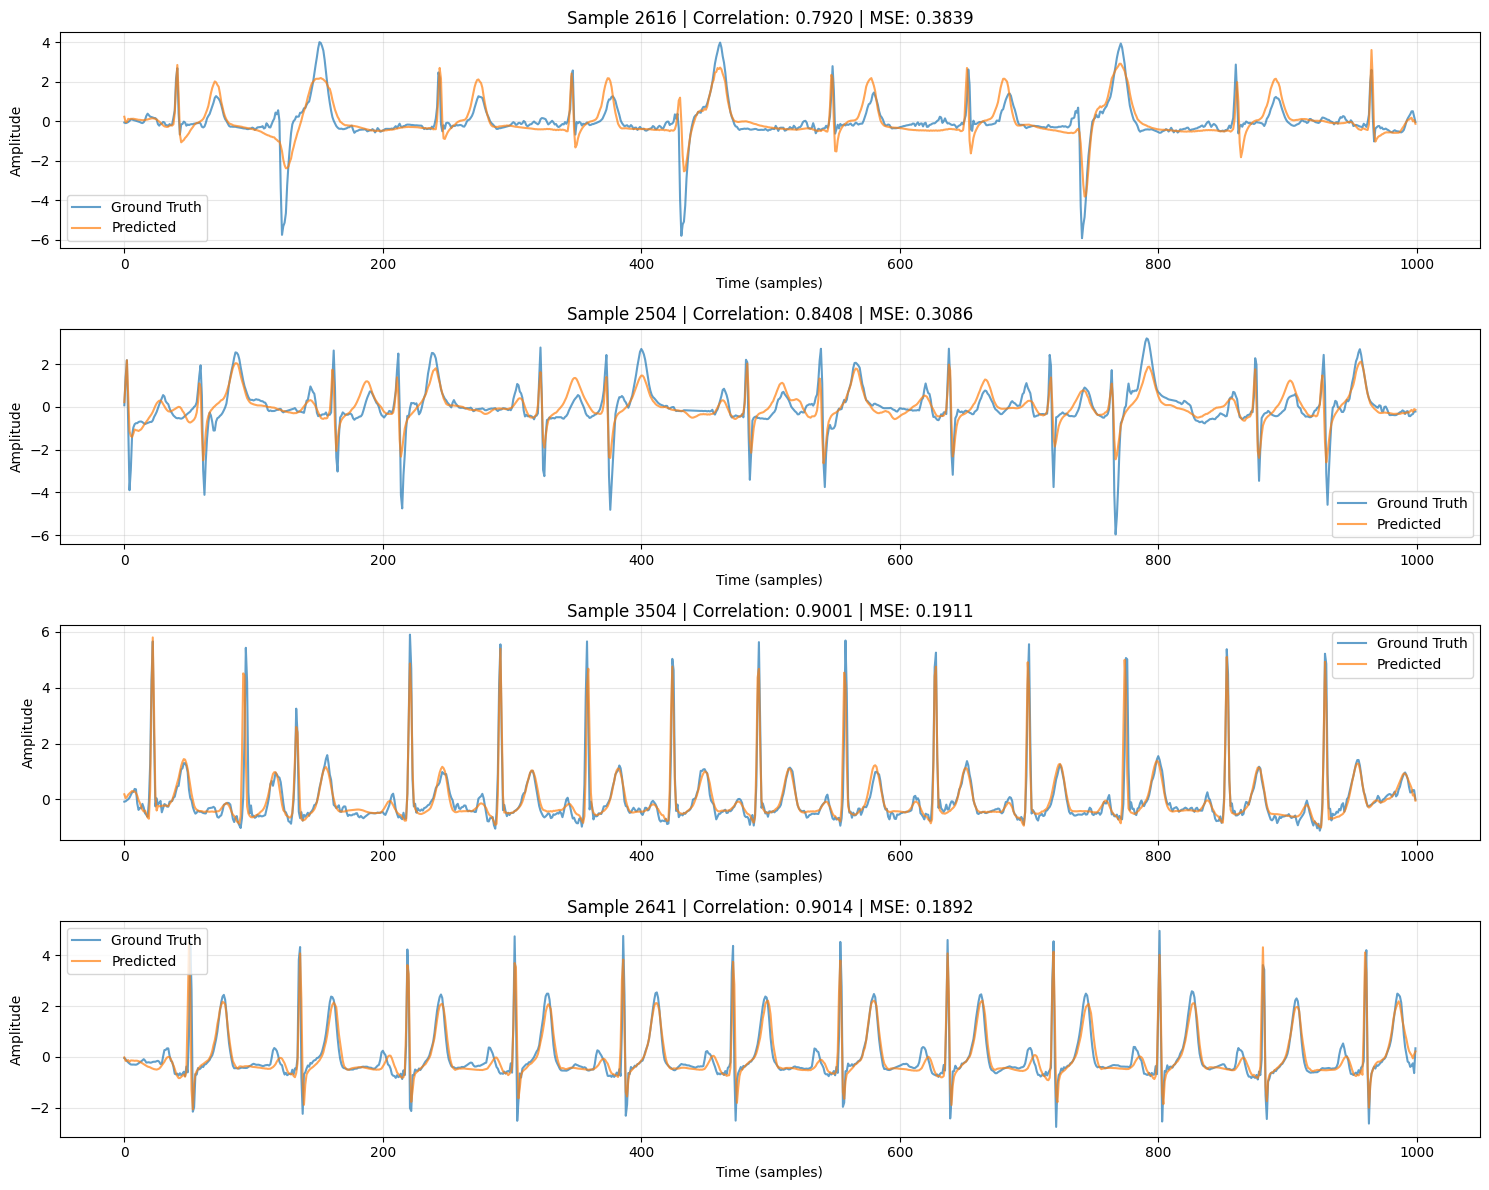


Epoch 11/80 | LR: 0.000030


  [Val] Loss: 0.2025 | MSE: 0.1823 | Pearson: 0.9029 | R-peak Err: 140.6 ms | Pred std: 0.9109
  >>> New BEST model saved (val_loss=0.2025)
  Train Loss: 0.2449 | Time: 96s | No improv: 0/20

Epoch 12/80 | LR: 0.000030


  [Val] Loss: 0.2065 | MSE: 0.1860 | Pearson: 0.9012 | R-peak Err: 138.3 ms | Pred std: 0.9224
  Train Loss: 0.2222 | Time: 96s | No improv: 1/20

Epoch 13/80 | LR: 0.000030


  [Val] Loss: 0.1755 | MSE: 0.1571 | Pearson: 0.9173 | R-peak Err: 136.6 ms | Pred std: 0.9337
  >>> New BEST model saved (val_loss=0.1755)
  Train Loss: 0.2034 | Time: 96s | No improv: 0/20

Epoch 14/80 | LR: 0.000030


  [Val] Loss: 0.1663 | MSE: 0.1475 | Pearson: 0.9226 | R-peak Err: 134.5 ms | Pred std: 0.9347
  >>> New BEST model saved (val_loss=0.1663)
  Train Loss: 0.1872 | Time: 96s | No improv: 0/20

Epoch 15/80 | LR: 0.000029


  [Val] Loss: 0.1563 | MSE: 0.1388 | Pearson: 0.9277 | R-peak Err: 131.1 ms | Pred std: 0.9542
  >>> New BEST model saved (val_loss=0.1563)
  Train Loss: 0.1740 | Time: 95s | No improv: 0/20

Epoch 16/80 | LR: 0.000029


  [Val] Loss: 0.1583 | MSE: 0.1398 | Pearson: 0.9270 | R-peak Err: 131.1 ms | Pred std: 0.9314
  Train Loss: 0.1617 | Time: 95s | No improv: 1/20

Epoch 17/80 | LR: 0.000029


  [Val] Loss: 0.1335 | MSE: 0.1172 | Pearson: 0.9389 | R-peak Err: 133.3 ms | Pred std: 0.9504
  >>> New BEST model saved (val_loss=0.1335)
  Train Loss: 0.1523 | Time: 96s | No improv: 0/20

Epoch 18/80 | LR: 0.000029


  [Val] Loss: 0.1321 | MSE: 0.1161 | Pearson: 0.9396 | R-peak Err: 132.8 ms | Pred std: 0.9544
  >>> New BEST model saved (val_loss=0.1321)
  Train Loss: 0.1437 | Time: 96s | No improv: 0/20

Epoch 19/80 | LR: 0.000029


  [Val] Loss: 0.1308 | MSE: 0.1148 | Pearson: 0.9408 | R-peak Err: 128.3 ms | Pred std: 0.9734
  >>> New BEST model saved (val_loss=0.1308)
  Train Loss: 0.1371 | Time: 95s | No improv: 0/20

Epoch 20/80 | LR: 0.000028


  [Val] Loss: 0.1201 | MSE: 0.1048 | Pearson: 0.9458 | R-peak Err: 126.9 ms | Pred std: 0.9651
  >>> New BEST model saved (val_loss=0.1201)
  Train Loss: 0.1301 | Time: 97s | No improv: 0/20
Saved comparison plot to checkpoints_final\epoch_20_comparison.png


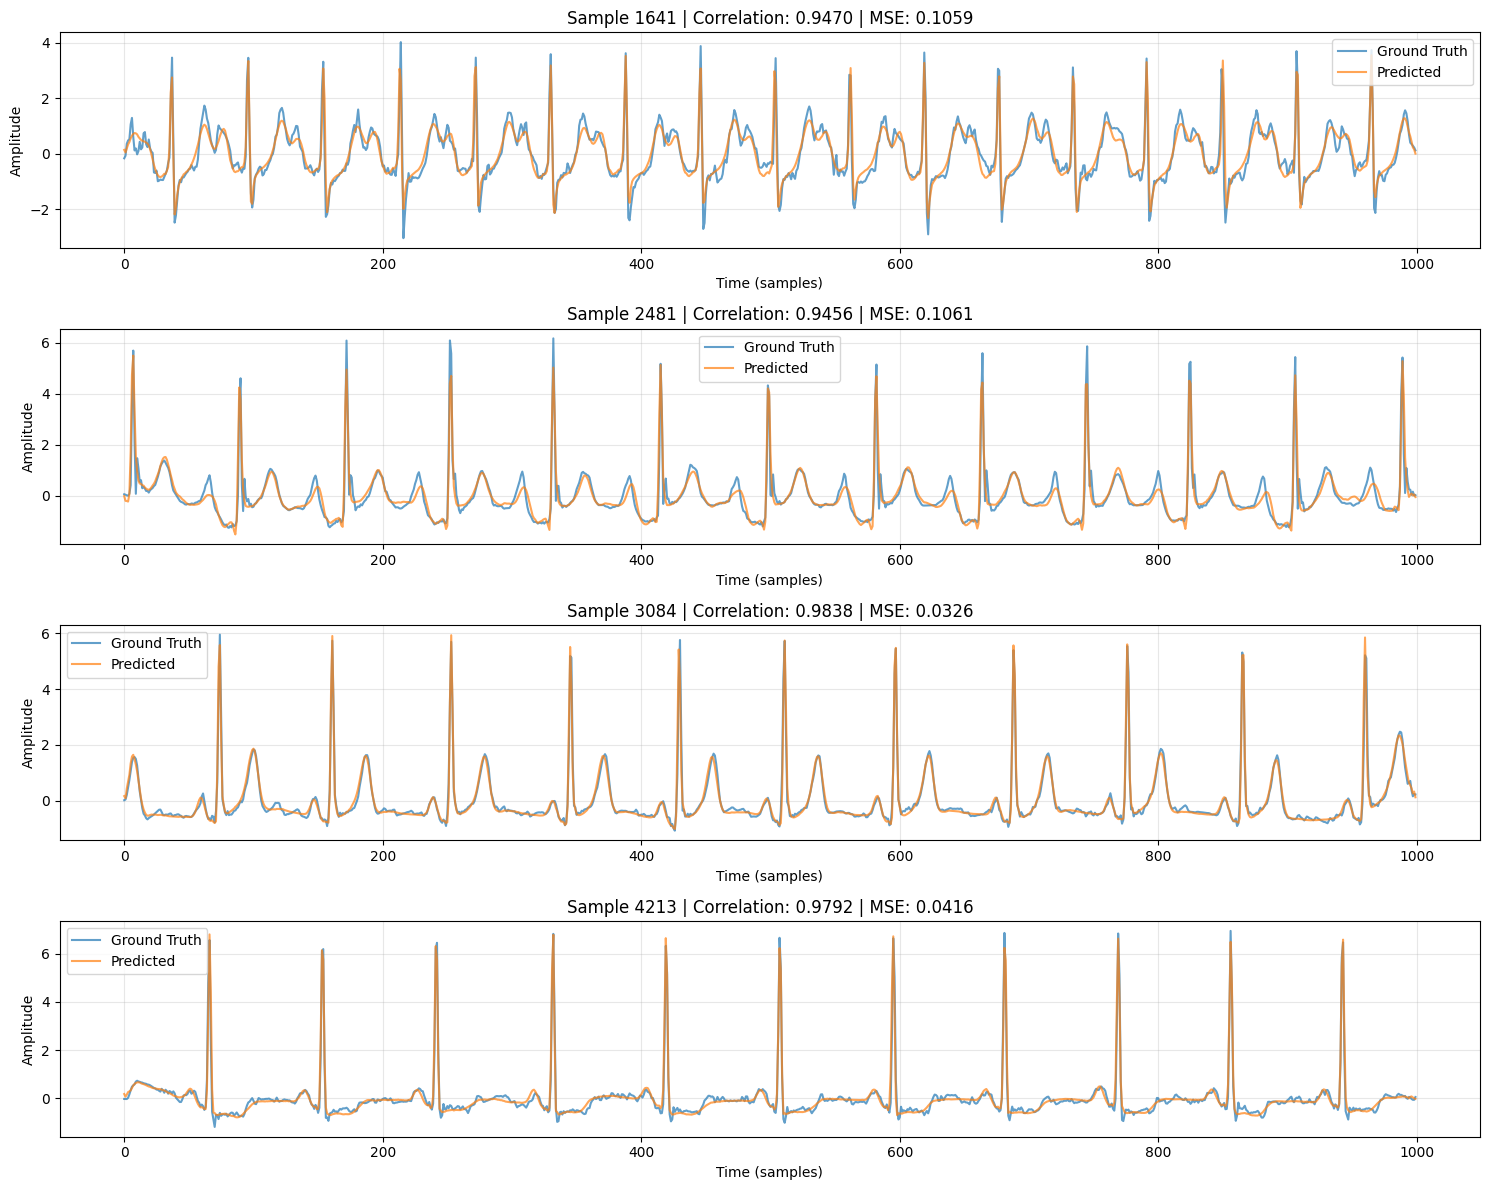


Epoch 21/80 | LR: 0.000028


  [Val] Loss: 0.1176 | MSE: 0.1028 | Pearson: 0.9472 | R-peak Err: 130.1 ms | Pred std: 0.9736
  >>> New BEST model saved (val_loss=0.1176)
  Train Loss: 0.1239 | Time: 96s | No improv: 0/20

Epoch 22/80 | LR: 0.000028


  [Val] Loss: 0.1188 | MSE: 0.1038 | Pearson: 0.9463 | R-peak Err: 127.5 ms | Pred std: 0.9471
  Train Loss: 0.1188 | Time: 96s | No improv: 1/20

Epoch 23/80 | LR: 0.000027


  [Val] Loss: 0.1098 | MSE: 0.0956 | Pearson: 0.9510 | R-peak Err: 122.6 ms | Pred std: 0.9813
  >>> New BEST model saved (val_loss=0.1098)
  Train Loss: 0.1141 | Time: 96s | No improv: 0/20

Epoch 24/80 | LR: 0.000027


  [Val] Loss: 0.1094 | MSE: 0.0955 | Pearson: 0.9510 | R-peak Err: 122.8 ms | Pred std: 0.9757
  >>> New BEST model saved (val_loss=0.1094)
  Train Loss: 0.1096 | Time: 96s | No improv: 0/20

Epoch 25/80 | LR: 0.000026


  [Val] Loss: 0.1035 | MSE: 0.0899 | Pearson: 0.9540 | R-peak Err: 119.5 ms | Pred std: 0.9845
  >>> New BEST model saved (val_loss=0.1035)
  Train Loss: 0.1058 | Time: 96s | No improv: 0/20

Epoch 26/80 | LR: 0.000026


  [Val] Loss: 0.0971 | MSE: 0.0843 | Pearson: 0.9565 | R-peak Err: 120.4 ms | Pred std: 0.9700
  >>> New BEST model saved (val_loss=0.0971)
  Train Loss: 0.1019 | Time: 95s | No improv: 0/20

Epoch 27/80 | LR: 0.000026


  [Val] Loss: 0.1042 | MSE: 0.0906 | Pearson: 0.9533 | R-peak Err: 126.2 ms | Pred std: 0.9663
  Train Loss: 0.0988 | Time: 96s | No improv: 1/20

Epoch 28/80 | LR: 0.000025


  [Val] Loss: 0.0942 | MSE: 0.0816 | Pearson: 0.9582 | R-peak Err: 119.2 ms | Pred std: 0.9821
  >>> New BEST model saved (val_loss=0.0942)
  Train Loss: 0.0957 | Time: 119s | No improv: 0/20

Epoch 29/80 | LR: 0.000025


  [Val] Loss: 0.0957 | MSE: 0.0831 | Pearson: 0.9573 | R-peak Err: 123.0 ms | Pred std: 0.9718
  Train Loss: 0.0931 | Time: 97s | No improv: 1/20

Epoch 30/80 | LR: 0.000024


  [Val] Loss: 0.0883 | MSE: 0.0763 | Pearson: 0.9608 | R-peak Err: 118.1 ms | Pred std: 0.9705
  >>> New BEST model saved (val_loss=0.0883)
  Train Loss: 0.0904 | Time: 97s | No improv: 0/20
Saved comparison plot to checkpoints_final\epoch_30_comparison.png


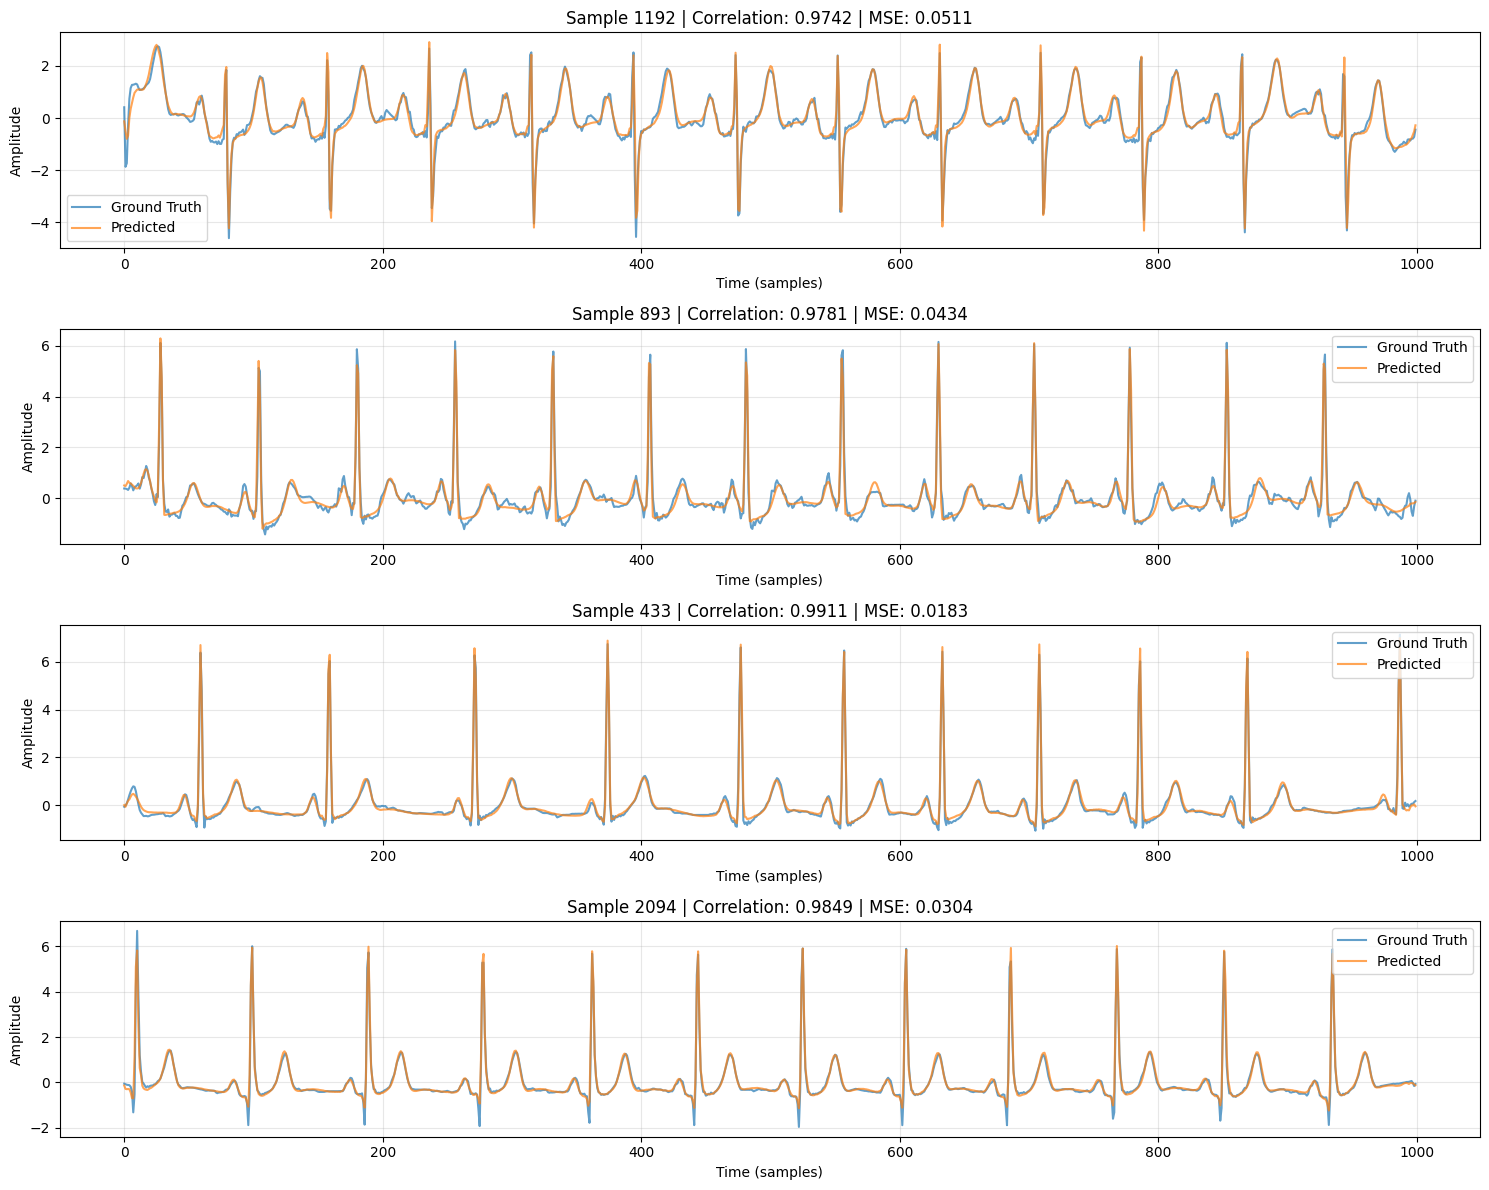


Epoch 31/80 | LR: 0.000024


  [Val] Loss: 0.0945 | MSE: 0.0821 | Pearson: 0.9583 | R-peak Err: 116.1 ms | Pred std: 0.9918
  Train Loss: 0.0875 | Time: 95s | No improv: 1/20

Epoch 32/80 | LR: 0.000023


  [Val] Loss: 0.0955 | MSE: 0.0827 | Pearson: 0.9576 | R-peak Err: 120.4 ms | Pred std: 0.9727
  Train Loss: 0.0854 | Time: 94s | No improv: 2/20

Epoch 33/80 | LR: 0.000023


  [Val] Loss: 0.0883 | MSE: 0.0762 | Pearson: 0.9608 | R-peak Err: 114.4 ms | Pred std: 0.9600
  Train Loss: 0.0833 | Time: 94s | No improv: 3/20

Epoch 34/80 | LR: 0.000022


  [Val] Loss: 0.0897 | MSE: 0.0773 | Pearson: 0.9606 | R-peak Err: 109.0 ms | Pred std: 0.9851
  Train Loss: 0.0812 | Time: 95s | No improv: 4/20

Epoch 35/80 | LR: 0.000021


  [Val] Loss: 0.0886 | MSE: 0.0767 | Pearson: 0.9609 | R-peak Err: 113.2 ms | Pred std: 0.9887
  Train Loss: 0.0791 | Time: 95s | No improv: 5/20

Epoch 36/80 | LR: 0.000021


  [Val] Loss: 0.0814 | MSE: 0.0702 | Pearson: 0.9641 | R-peak Err: 107.6 ms | Pred std: 0.9779
  >>> New BEST model saved (val_loss=0.0814)
  Train Loss: 0.0772 | Time: 96s | No improv: 0/20

Epoch 37/80 | LR: 0.000020


  [Val] Loss: 0.0802 | MSE: 0.0692 | Pearson: 0.9646 | R-peak Err: 109.7 ms | Pred std: 0.9838
  >>> New BEST model saved (val_loss=0.0802)
  Train Loss: 0.0755 | Time: 95s | No improv: 0/20

Epoch 38/80 | LR: 0.000020


  [Val] Loss: 0.0791 | MSE: 0.0681 | Pearson: 0.9650 | R-peak Err: 113.8 ms | Pred std: 0.9696
  >>> New BEST model saved (val_loss=0.0791)
  Train Loss: 0.0736 | Time: 94s | No improv: 0/20

Epoch 39/80 | LR: 0.000019


  [Val] Loss: 0.0801 | MSE: 0.0691 | Pearson: 0.9649 | R-peak Err: 105.8 ms | Pred std: 0.9941
  Train Loss: 0.0721 | Time: 94s | No improv: 1/20

Epoch 40/80 | LR: 0.000018


  [Val] Loss: 0.0790 | MSE: 0.0679 | Pearson: 0.9652 | R-peak Err: 107.7 ms | Pred std: 0.9756
  >>> New BEST model saved (val_loss=0.0790)
  Train Loss: 0.0706 | Time: 94s | No improv: 0/20
Saved comparison plot to checkpoints_final\epoch_40_comparison.png


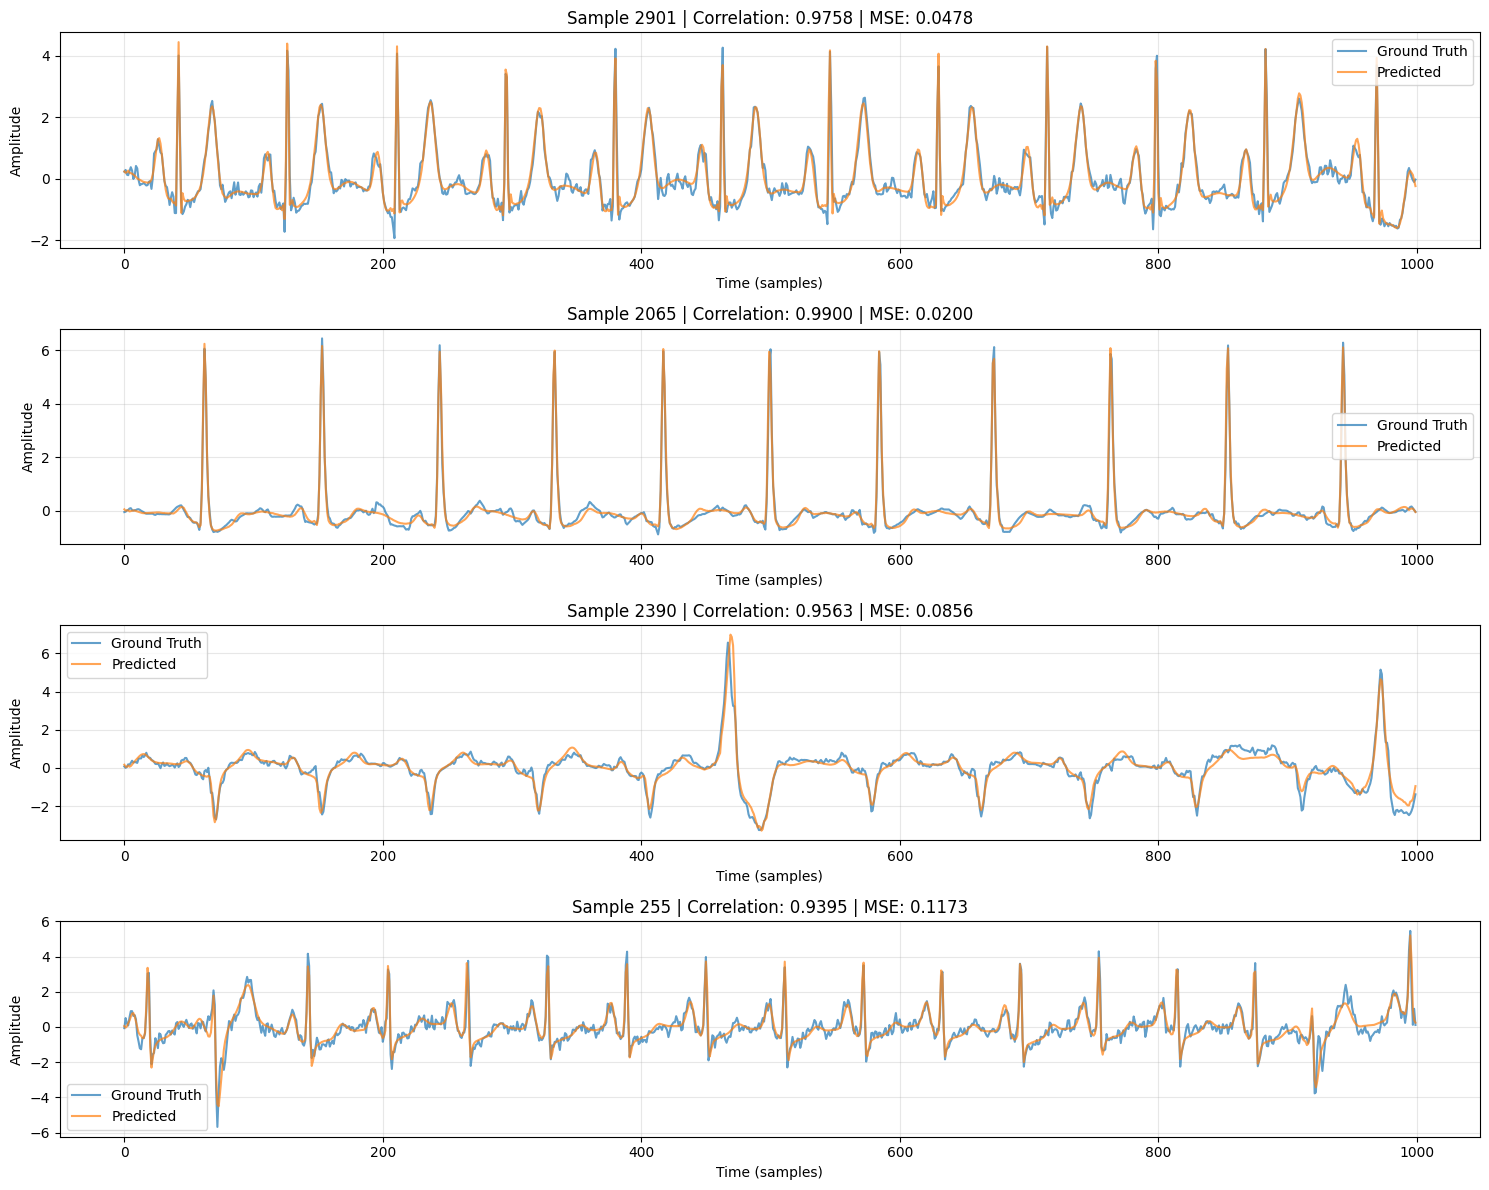


Epoch 41/80 | LR: 0.000018


  [Val] Loss: 0.0780 | MSE: 0.0673 | Pearson: 0.9657 | R-peak Err: 109.0 ms | Pred std: 0.9889
  >>> New BEST model saved (val_loss=0.0780)
  Train Loss: 0.0691 | Time: 94s | No improv: 0/20

Epoch 42/80 | LR: 0.000017


  [Val] Loss: 0.0791 | MSE: 0.0681 | Pearson: 0.9653 | R-peak Err: 109.4 ms | Pred std: 0.9875
  Train Loss: 0.0680 | Time: 94s | No improv: 1/20

Epoch 43/80 | LR: 0.000016


  [Val] Loss: 0.0763 | MSE: 0.0657 | Pearson: 0.9664 | R-peak Err: 107.5 ms | Pred std: 0.9815
  >>> New BEST model saved (val_loss=0.0763)
  Train Loss: 0.0665 | Time: 94s | No improv: 0/20

Epoch 44/80 | LR: 0.000016


  [Val] Loss: 0.0745 | MSE: 0.0641 | Pearson: 0.9672 | R-peak Err: 105.3 ms | Pred std: 0.9844
  >>> New BEST model saved (val_loss=0.0745)
  Train Loss: 0.0653 | Time: 94s | No improv: 0/20

Epoch 45/80 | LR: 0.000015


  [Val] Loss: 0.0722 | MSE: 0.0621 | Pearson: 0.9683 | R-peak Err: 106.5 ms | Pred std: 0.9829
  >>> New BEST model saved (val_loss=0.0722)
  Train Loss: 0.0639 | Time: 94s | No improv: 0/20

Epoch 46/80 | LR: 0.000014


  [Val] Loss: 0.0744 | MSE: 0.0640 | Pearson: 0.9674 | R-peak Err: 106.4 ms | Pred std: 0.9866
  Train Loss: 0.0628 | Time: 95s | No improv: 1/20

Epoch 47/80 | LR: 0.000014


  [Val] Loss: 0.0724 | MSE: 0.0624 | Pearson: 0.9684 | R-peak Err: 102.2 ms | Pred std: 0.9964
  Train Loss: 0.0618 | Time: 95s | No improv: 2/20

Epoch 48/80 | LR: 0.000013


  [Val] Loss: 0.0706 | MSE: 0.0607 | Pearson: 0.9689 | R-peak Err: 103.1 ms | Pred std: 0.9799
  >>> New BEST model saved (val_loss=0.0706)
  Train Loss: 0.0609 | Time: 94s | No improv: 0/20

Epoch 49/80 | LR: 0.000012


  [Val] Loss: 0.0709 | MSE: 0.0610 | Pearson: 0.9689 | R-peak Err: 102.5 ms | Pred std: 0.9813
  Train Loss: 0.0599 | Time: 94s | No improv: 1/20

Epoch 50/80 | LR: 0.000012


  [Val] Loss: 0.0723 | MSE: 0.0622 | Pearson: 0.9683 | R-peak Err: 101.8 ms | Pred std: 0.9908
  Train Loss: 0.0588 | Time: 94s | No improv: 2/20
Saved comparison plot to checkpoints_final\epoch_50_comparison.png


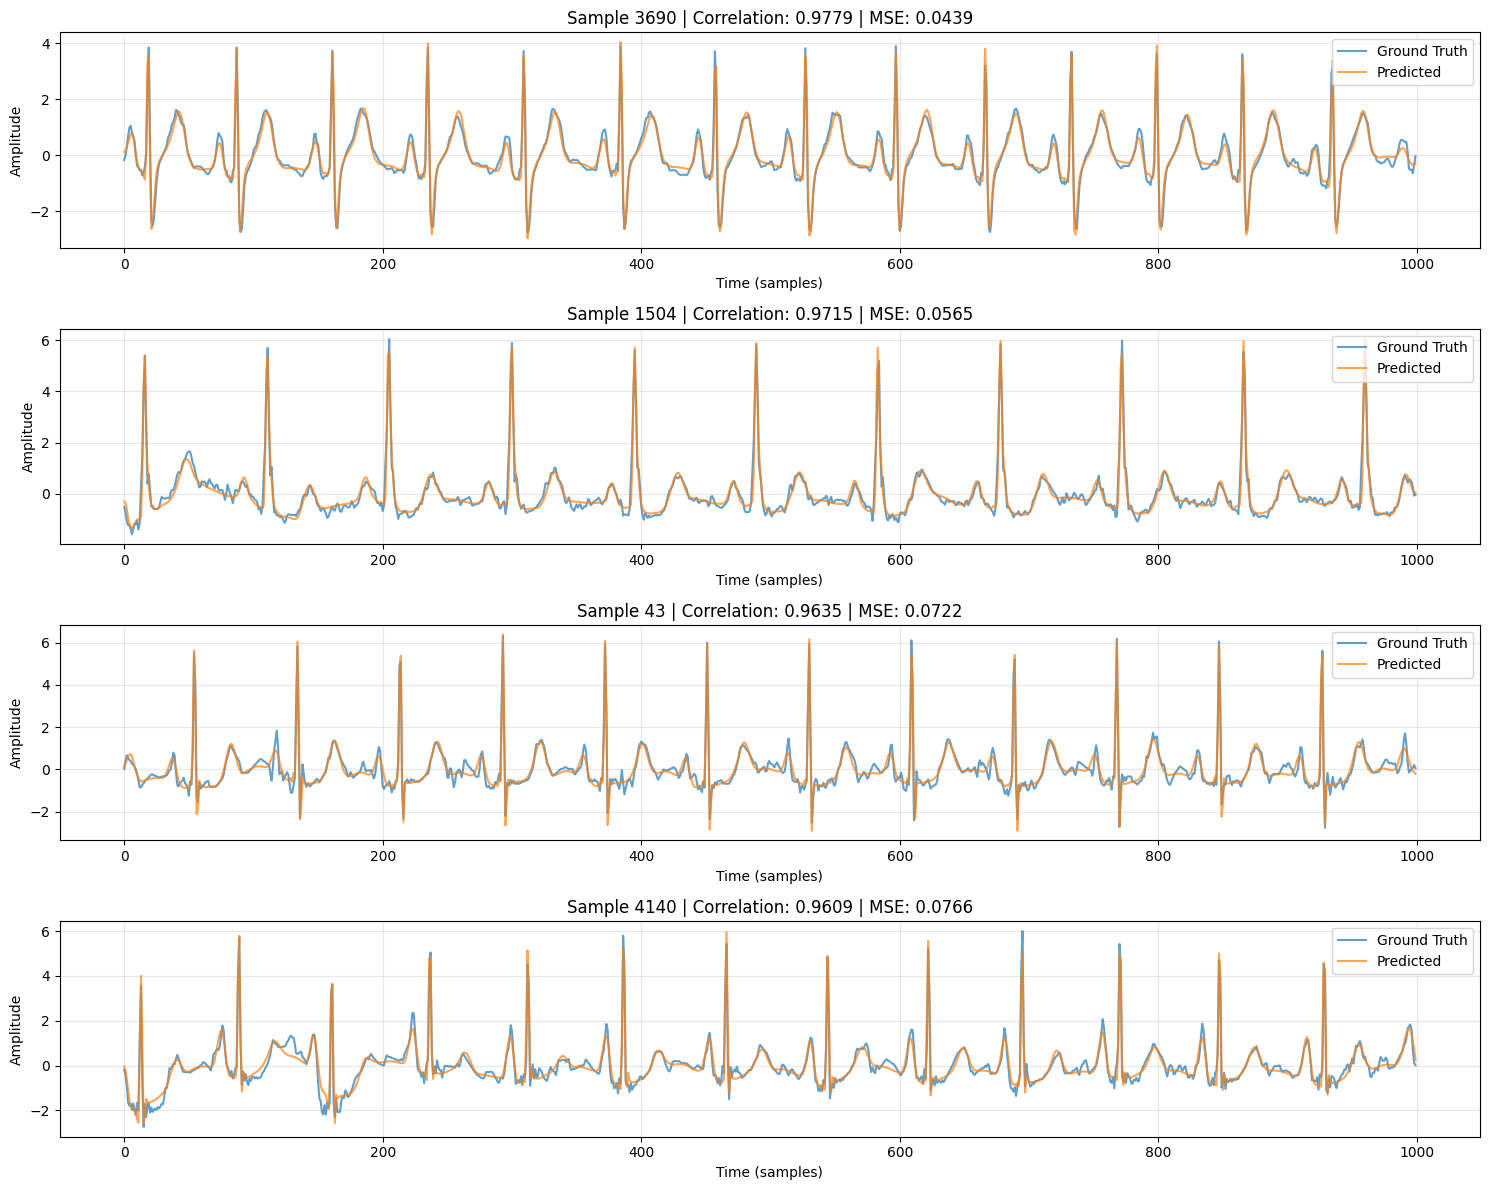


Epoch 51/80 | LR: 0.000011


  [Val] Loss: 0.0695 | MSE: 0.0598 | Pearson: 0.9696 | R-peak Err: 101.0 ms | Pred std: 0.9899
  >>> New BEST model saved (val_loss=0.0695)
  Train Loss: 0.0580 | Time: 94s | No improv: 0/20

Epoch 52/80 | LR: 0.000011


  [Val] Loss: 0.0701 | MSE: 0.0602 | Pearson: 0.9692 | R-peak Err: 101.2 ms | Pred std: 0.9800
  Train Loss: 0.0571 | Time: 94s | No improv: 1/20

Epoch 53/80 | LR: 0.000010


  [Val] Loss: 0.0692 | MSE: 0.0596 | Pearson: 0.9698 | R-peak Err: 98.5 ms | Pred std: 0.9947
  >>> New BEST model saved (val_loss=0.0692)
  Train Loss: 0.0564 | Time: 94s | No improv: 0/20

Epoch 54/80 | LR: 0.000009


  [Val] Loss: 0.0694 | MSE: 0.0598 | Pearson: 0.9695 | R-peak Err: 98.8 ms | Pred std: 0.9891
  Train Loss: 0.0556 | Time: 94s | No improv: 1/20

Epoch 55/80 | LR: 0.000009


  [Val] Loss: 0.0680 | MSE: 0.0585 | Pearson: 0.9704 | R-peak Err: 98.2 ms | Pred std: 0.9968
  >>> New BEST model saved (val_loss=0.0680)
  Train Loss: 0.0549 | Time: 94s | No improv: 0/20

Epoch 56/80 | LR: 0.000008


  [Val] Loss: 0.0675 | MSE: 0.0580 | Pearson: 0.9705 | R-peak Err: 97.8 ms | Pred std: 0.9892
  >>> New BEST model saved (val_loss=0.0675)
  Train Loss: 0.0542 | Time: 94s | No improv: 0/20

Epoch 57/80 | LR: 0.000008


  [Val] Loss: 0.0673 | MSE: 0.0579 | Pearson: 0.9706 | R-peak Err: 96.8 ms | Pred std: 0.9930
  >>> New BEST model saved (val_loss=0.0673)
  Train Loss: 0.0537 | Time: 94s | No improv: 0/20

Epoch 58/80 | LR: 0.000007


  [Val] Loss: 0.0671 | MSE: 0.0577 | Pearson: 0.9705 | R-peak Err: 98.7 ms | Pred std: 0.9833
  >>> New BEST model saved (val_loss=0.0671)
  Train Loss: 0.0531 | Time: 94s | No improv: 0/20

Epoch 59/80 | LR: 0.000006


  [Val] Loss: 0.0667 | MSE: 0.0575 | Pearson: 0.9709 | R-peak Err: 97.6 ms | Pred std: 0.9941
  >>> New BEST model saved (val_loss=0.0667)
  Train Loss: 0.0523 | Time: 94s | No improv: 0/20

Epoch 60/80 | LR: 0.000006


  [Val] Loss: 0.0659 | MSE: 0.0566 | Pearson: 0.9711 | R-peak Err: 97.1 ms | Pred std: 0.9876
  >>> New BEST model saved (val_loss=0.0659)
  Train Loss: 0.0520 | Time: 94s | No improv: 0/20
Saved comparison plot to checkpoints_final\epoch_60_comparison.png


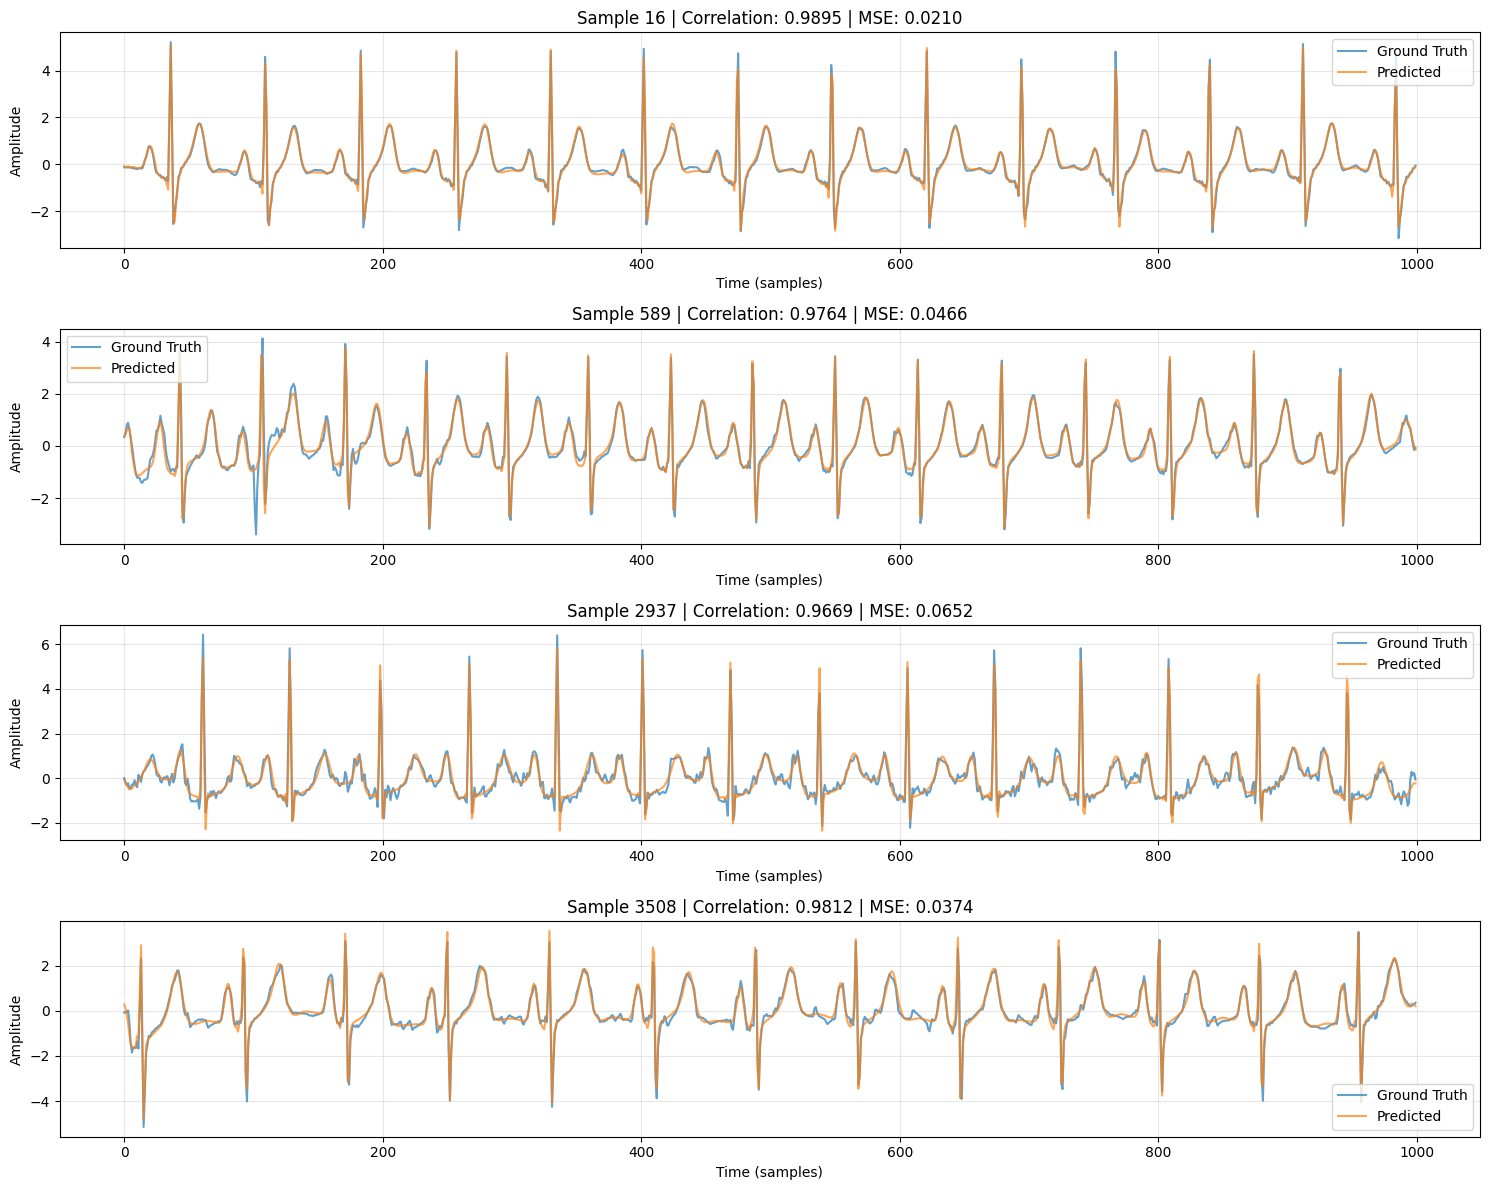


Epoch 61/80 | LR: 0.000005


  [Val] Loss: 0.0663 | MSE: 0.0570 | Pearson: 0.9710 | R-peak Err: 97.6 ms | Pred std: 0.9906
  Train Loss: 0.0514 | Time: 94s | No improv: 1/20

Epoch 62/80 | LR: 0.000005


  [Val] Loss: 0.0659 | MSE: 0.0567 | Pearson: 0.9711 | R-peak Err: 96.5 ms | Pred std: 0.9895
  Train Loss: 0.0509 | Time: 94s | No improv: 2/20

Epoch 63/80 | LR: 0.000004


  [Val] Loss: 0.0655 | MSE: 0.0563 | Pearson: 0.9713 | R-peak Err: 95.8 ms | Pred std: 0.9896
  >>> New BEST model saved (val_loss=0.0655)
  Train Loss: 0.0506 | Time: 94s | No improv: 0/20

Epoch 64/80 | LR: 0.000004


  [Val] Loss: 0.0651 | MSE: 0.0560 | Pearson: 0.9715 | R-peak Err: 97.4 ms | Pred std: 0.9909
  >>> New BEST model saved (val_loss=0.0651)
  Train Loss: 0.0501 | Time: 94s | No improv: 0/20

Epoch 65/80 | LR: 0.000004


  [Val] Loss: 0.0652 | MSE: 0.0561 | Pearson: 0.9714 | R-peak Err: 95.7 ms | Pred std: 0.9893
  Train Loss: 0.0497 | Time: 94s | No improv: 1/20

Epoch 66/80 | LR: 0.000003


  [Val] Loss: 0.0648 | MSE: 0.0557 | Pearson: 0.9716 | R-peak Err: 94.3 ms | Pred std: 0.9888
  >>> New BEST model saved (val_loss=0.0648)
  Train Loss: 0.0494 | Time: 94s | No improv: 0/20

Epoch 67/80 | LR: 0.000003


  [Val] Loss: 0.0652 | MSE: 0.0561 | Pearson: 0.9714 | R-peak Err: 96.0 ms | Pred std: 0.9884
  Train Loss: 0.0491 | Time: 94s | No improv: 1/20

Epoch 68/80 | LR: 0.000002


  [Val] Loss: 0.0647 | MSE: 0.0556 | Pearson: 0.9717 | R-peak Err: 95.3 ms | Pred std: 0.9911
  >>> New BEST model saved (val_loss=0.0647)
  Train Loss: 0.0487 | Time: 94s | No improv: 0/20

Epoch 69/80 | LR: 0.000002


  [Val] Loss: 0.0649 | MSE: 0.0558 | Pearson: 0.9716 | R-peak Err: 95.0 ms | Pred std: 0.9918
  Train Loss: 0.0485 | Time: 94s | No improv: 1/20

Epoch 70/80 | LR: 0.000002


  [Val] Loss: 0.0647 | MSE: 0.0556 | Pearson: 0.9717 | R-peak Err: 94.7 ms | Pred std: 0.9936
  >>> New BEST model saved (val_loss=0.0647)
  Train Loss: 0.0482 | Time: 94s | No improv: 0/20
Saved comparison plot to checkpoints_final\epoch_70_comparison.png


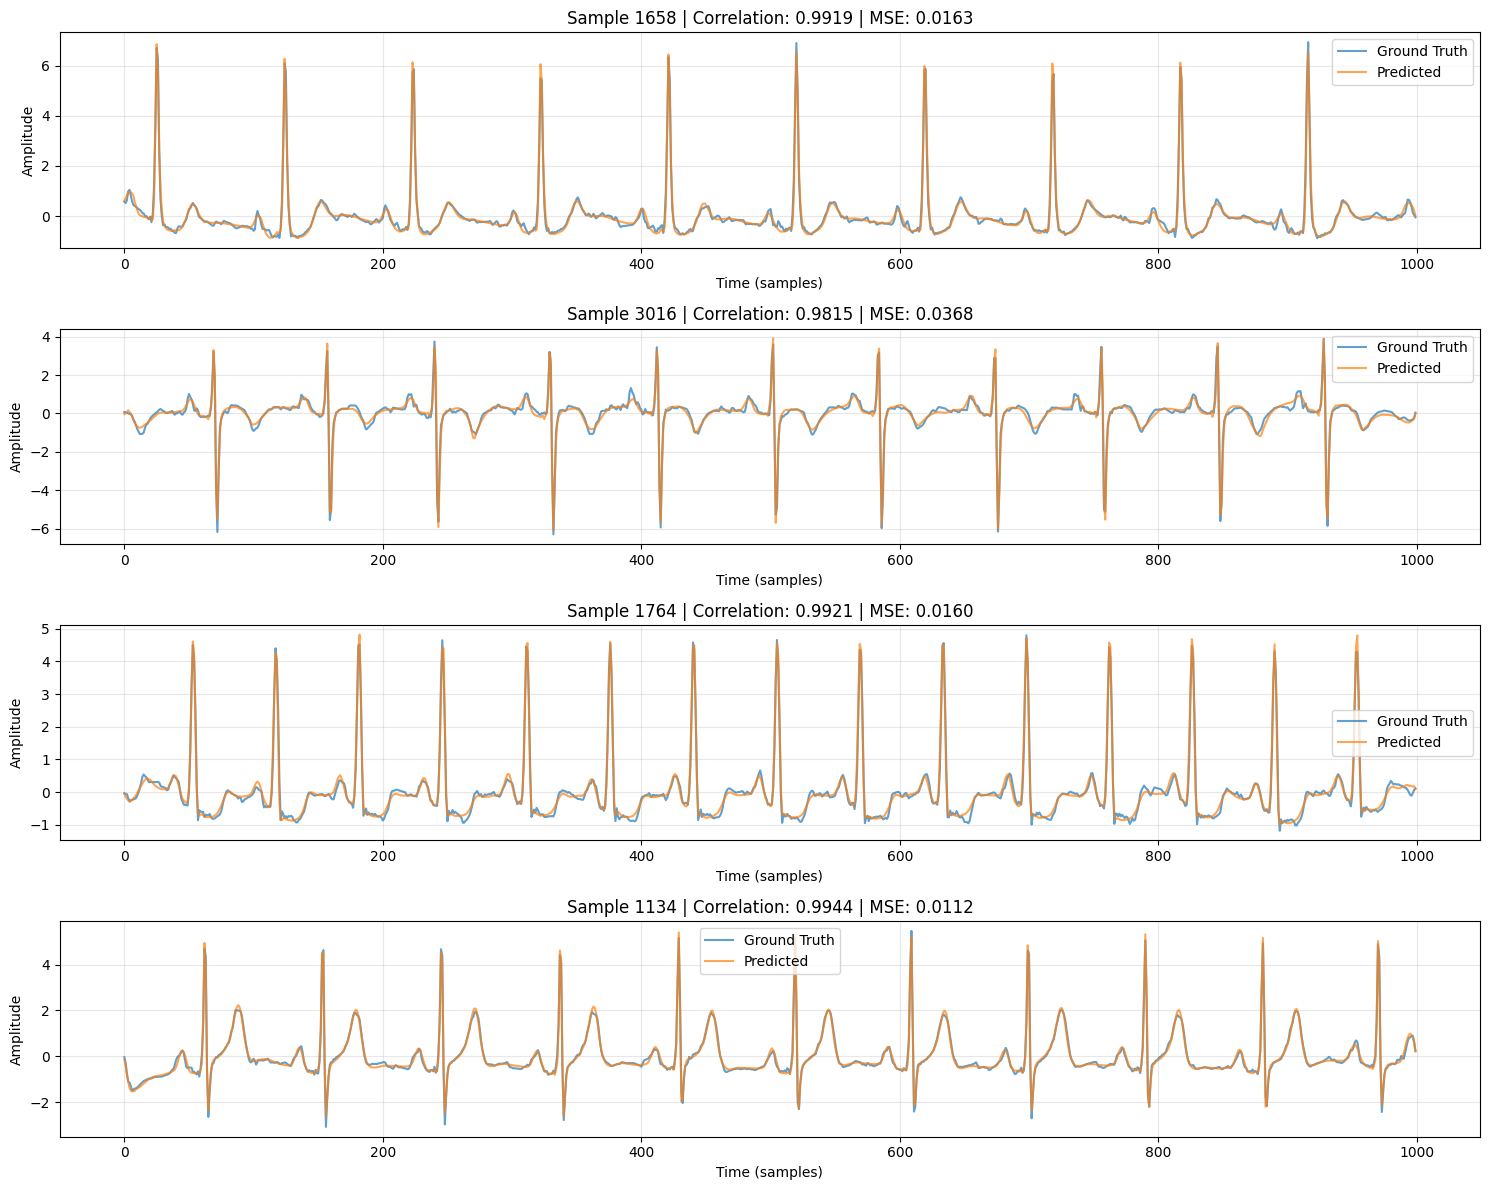


Epoch 71/80 | LR: 0.000001


  [Val] Loss: 0.0646 | MSE: 0.0556 | Pearson: 0.9718 | R-peak Err: 93.3 ms | Pred std: 0.9947
  >>> New BEST model saved (val_loss=0.0646)
  Train Loss: 0.0480 | Time: 94s | No improv: 0/20

Epoch 72/80 | LR: 0.000001


  [Val] Loss: 0.0643 | MSE: 0.0554 | Pearson: 0.9719 | R-peak Err: 94.3 ms | Pred std: 0.9920
  >>> New BEST model saved (val_loss=0.0643)
  Train Loss: 0.0479 | Time: 94s | No improv: 0/20

Epoch 73/80 | LR: 0.000001


  [Val] Loss: 0.0642 | MSE: 0.0552 | Pearson: 0.9719 | R-peak Err: 94.4 ms | Pred std: 0.9910
  >>> New BEST model saved (val_loss=0.0642)
  Train Loss: 0.0477 | Time: 94s | No improv: 0/20

Epoch 74/80 | LR: 0.000001


  [Val] Loss: 0.0640 | MSE: 0.0551 | Pearson: 0.9720 | R-peak Err: 94.0 ms | Pred std: 0.9916
  >>> New BEST model saved (val_loss=0.0640)
  Train Loss: 0.0475 | Time: 94s | No improv: 0/20

Epoch 75/80 | LR: 0.000001


  [Val] Loss: 0.0641 | MSE: 0.0552 | Pearson: 0.9719 | R-peak Err: 93.9 ms | Pred std: 0.9918
  Train Loss: 0.0475 | Time: 94s | No improv: 1/20

Epoch 76/80 | LR: 0.000000


  [Val] Loss: 0.0641 | MSE: 0.0552 | Pearson: 0.9719 | R-peak Err: 94.0 ms | Pred std: 0.9931
  Train Loss: 0.0474 | Time: 94s | No improv: 2/20

Epoch 77/80 | LR: 0.000000


  [Val] Loss: 0.0640 | MSE: 0.0551 | Pearson: 0.9720 | R-peak Err: 93.5 ms | Pred std: 0.9933
  >>> New BEST model saved (val_loss=0.0640)
  Train Loss: 0.0473 | Time: 94s | No improv: 0/20

Epoch 78/80 | LR: 0.000000


  [Val] Loss: 0.0640 | MSE: 0.0551 | Pearson: 0.9720 | R-peak Err: 93.2 ms | Pred std: 0.9925
  Train Loss: 0.0472 | Time: 94s | No improv: 1/20

Epoch 79/80 | LR: 0.000000


  [Val] Loss: 0.0639 | MSE: 0.0550 | Pearson: 0.9720 | R-peak Err: 93.0 ms | Pred std: 0.9914
  >>> New BEST model saved (val_loss=0.0639)
  Train Loss: 0.0472 | Time: 94s | No improv: 0/20

Epoch 80/80 | LR: 0.000000


  [Val] Loss: 0.0640 | MSE: 0.0551 | Pearson: 0.9720 | R-peak Err: 93.3 ms | Pred std: 0.9920
  Train Loss: 0.0472 | Time: 94s | No improv: 1/20
Saved comparison plot to checkpoints_final\epoch_80_comparison.png


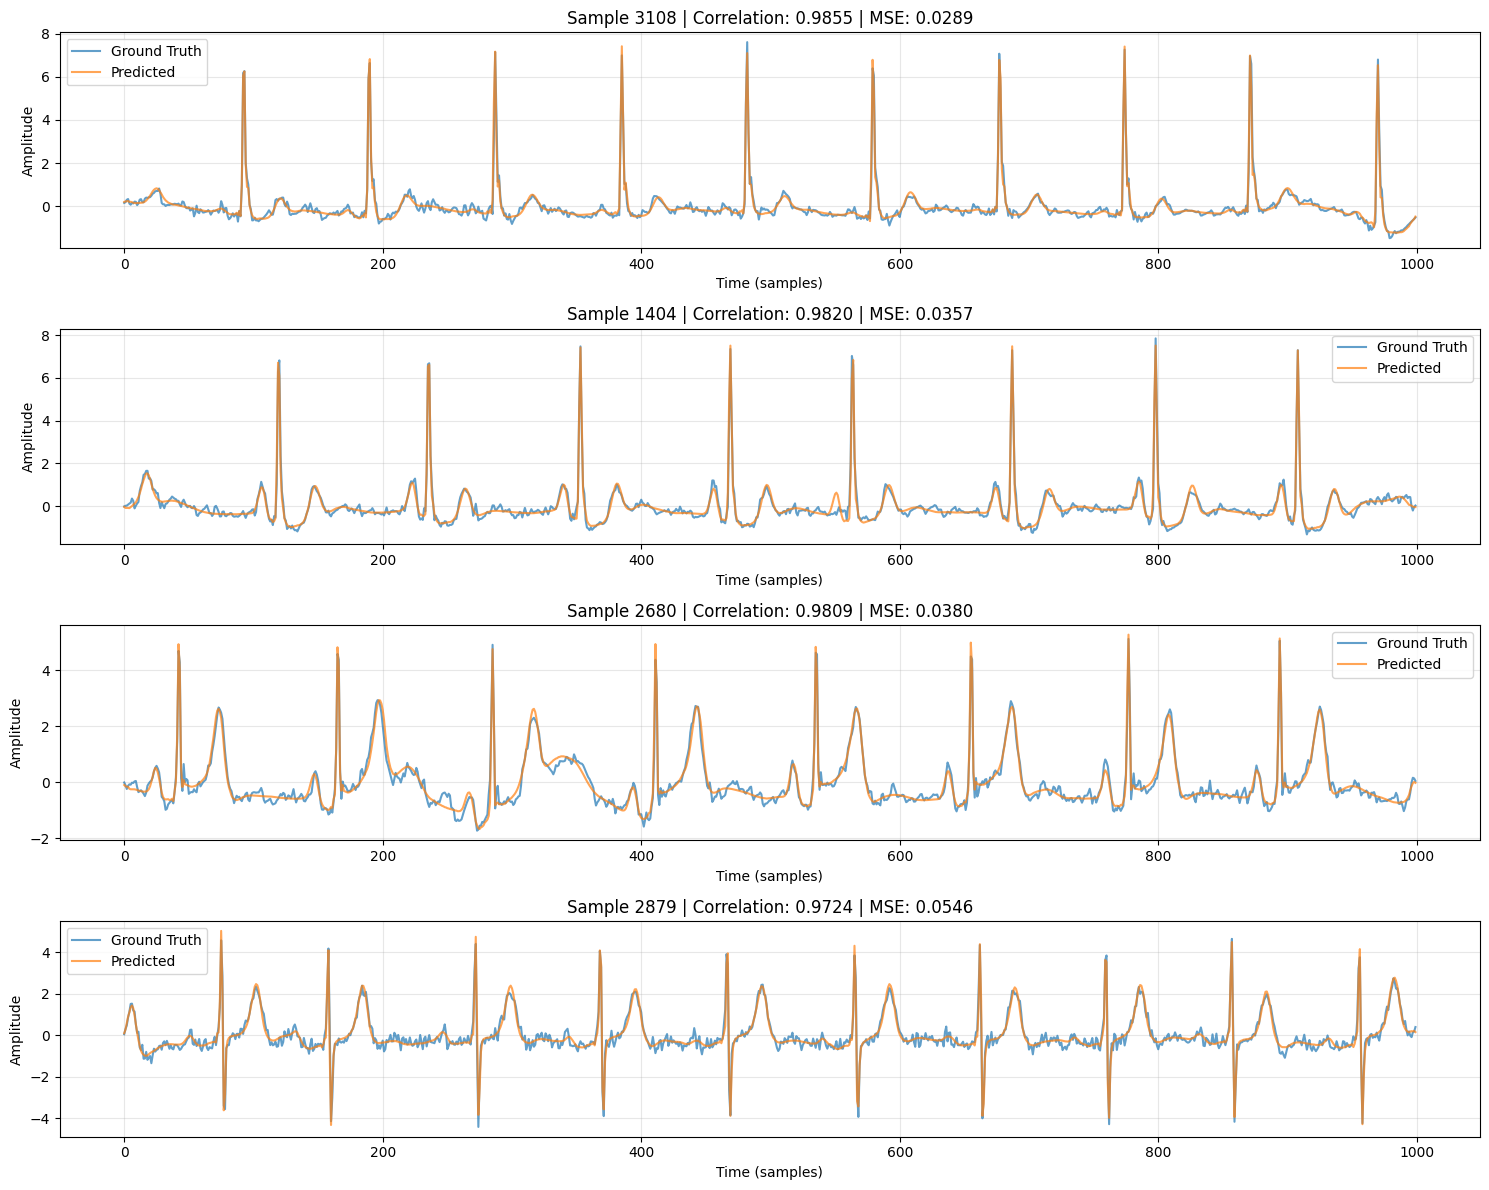


Done! Best val loss: 0.0639
Total time: 128.0 min (2.13 h)

Wall-clock time: 2.14 hours


In [7]:
# Cell 7: Run Training

trainer = ECGTrainerFinal(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=CONFIG['device'],
    ckpt_dir=CONFIG['checkpoint_dir'],
    patience=CONFIG['patience'],
)

t_start = time.time()
history = trainer.train(num_epochs=CONFIG['num_epochs'])
print(f"\nWall-clock time: {(time.time() - t_start) / 3600:.2f} hours")

## 6. Training Curves

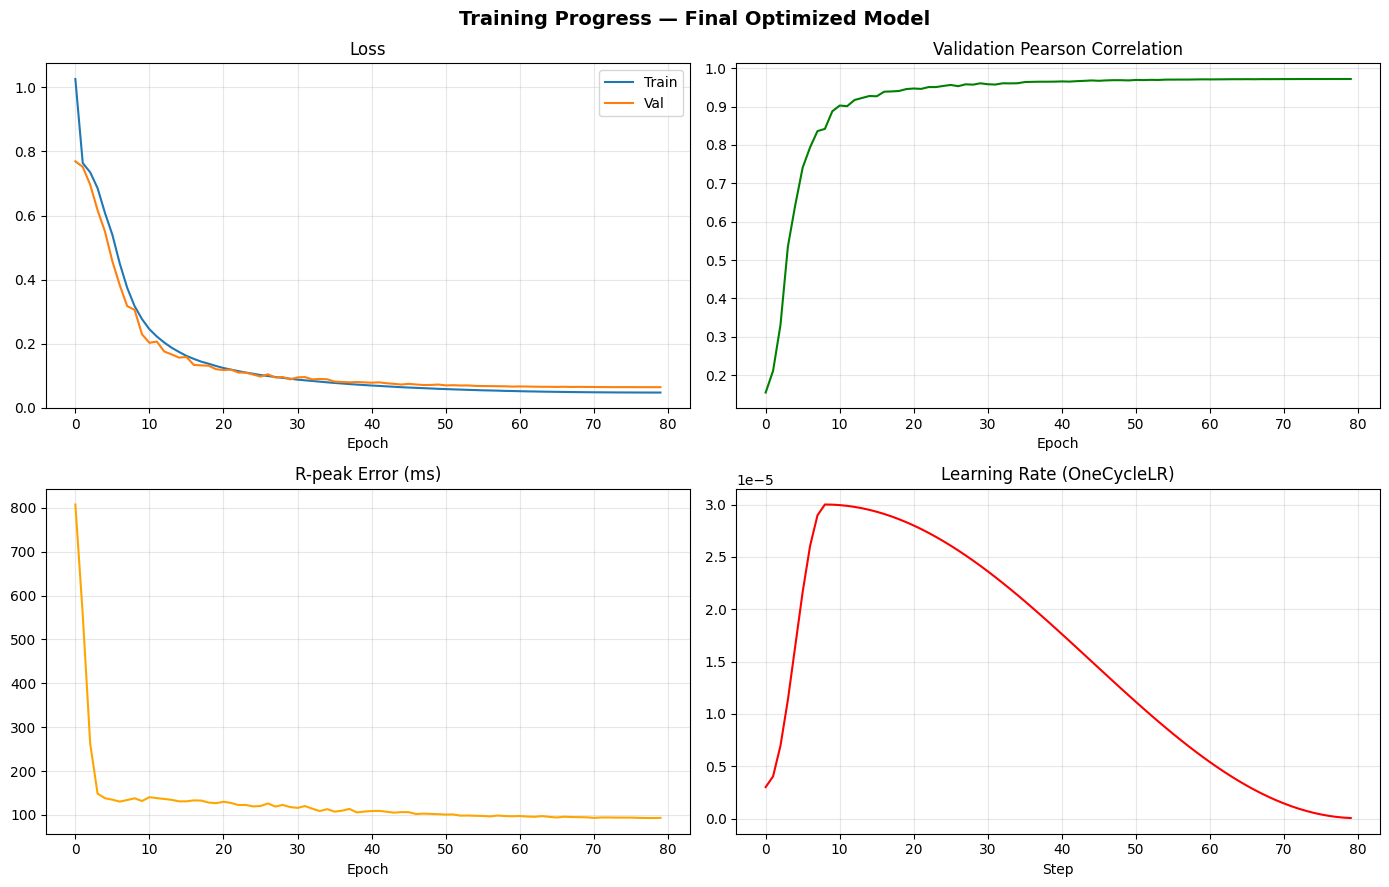


Best Val Loss:    0.0639
Best Pearson:     0.9720
Best R-peak Err:  93.0 ms
Avg Epoch Time:   96.0s


In [8]:
# Cell 8: Visualize training progress

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

axes[0, 0].plot(history['train_loss'], label='Train', linewidth=1.5)
axes[0, 0].plot(history['val_loss'], label='Val', linewidth=1.5)
axes[0, 0].set_title('Loss'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlabel('Epoch')

axes[0, 1].plot(history['val_pearson'], color='green', linewidth=1.5)
axes[0, 1].set_title('Validation Pearson Correlation'); axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlabel('Epoch')

axes[1, 0].plot(history['val_rpeak_err'], color='orange', linewidth=1.5)
axes[1, 0].set_title('R-peak Error (ms)'); axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('Epoch')

axes[1, 1].plot(history['lr'], color='red', linewidth=1.5)
axes[1, 1].set_title('Learning Rate (OneCycleLR)'); axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlabel('Step')

plt.suptitle('Training Progress — Final Optimized Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print(f"\nBest Val Loss:    {min(history['val_loss']):.4f}")
print(f"Best Pearson:     {max(history['val_pearson']):.4f}")
print(f"Best R-peak Err:  {min(history['val_rpeak_err']):.1f} ms")
print(f"Avg Epoch Time:   {np.mean(history['epoch_time']):.1f}s")

## 7. Evaluate Best Model

In [9]:
# Cell 9: Load best model and run final evaluation

best_path = os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth')
if os.path.exists(best_path):
    trainer.load_checkpoint(best_path)
    print("Loaded best model\n")

val_loss, val_pearson, val_rpeak, preds, targets = trainer._validate(0)

print(f"\n{'='*50}")
print(f"FINAL RESULTS (signal_length={CONFIG['signal_length']})")
print(f"{'='*50}")
print(f"  Validation Loss:        {val_loss:.4f}")
print(f"  Pearson Correlation:    {val_pearson:.4f}")
print(f"  R-peak Error:           {val_rpeak:.1f} ms")
print(f"{'='*50}")

Resumed from epoch 79
Loaded best model



  [Val] Loss: 0.0532 | MSE: 0.0550 | Pearson: 0.9720 | R-peak Err: 93.0 ms | Pred std: 0.9914

FINAL RESULTS (signal_length=1000)
  Validation Loss:        0.0532
  Pearson Correlation:    0.9720
  R-peak Error:           93.0 ms


COMPREHENSIVE ACCURACY REPORT
Evaluated on 4360 validation samples

────────────────────────────────────────
1. SIGNAL RECONSTRUCTION QUALITY
────────────────────────────────────────
  Mean Pearson Correlation:  0.9720 ± 0.0362
  Median Pearson Corr:       0.9830
  Mean R² Score:             0.9451 ± 0.0672
  Mean RMSE:                 0.2107 ± 0.1026
  Mean MAE:                  0.1435 ± 0.0689
  Mean SNR:                  14.4 ± 3.7 dB

────────────────────────────────────────
2. ACCURACY AT CORRELATION THRESHOLDS
────────────────────────────────────────
  Corr ≥ 0.70: █████████████████████████████████████████████████░ 99.8%
  Corr ≥ 0.80: █████████████████████████████████████████████████░ 99.2%
  Corr ≥ 0.90: ████████████████████████████████████████████████░░ 96.3%
  Corr ≥ 0.95: ███████████████████████████████████████████░░░░░░░ 86.6%
  Corr ≥ 0.99: █████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 27.1%

────────────────────────────────────────
3. R-PEAK DETECTION ACCURACY (±50ms

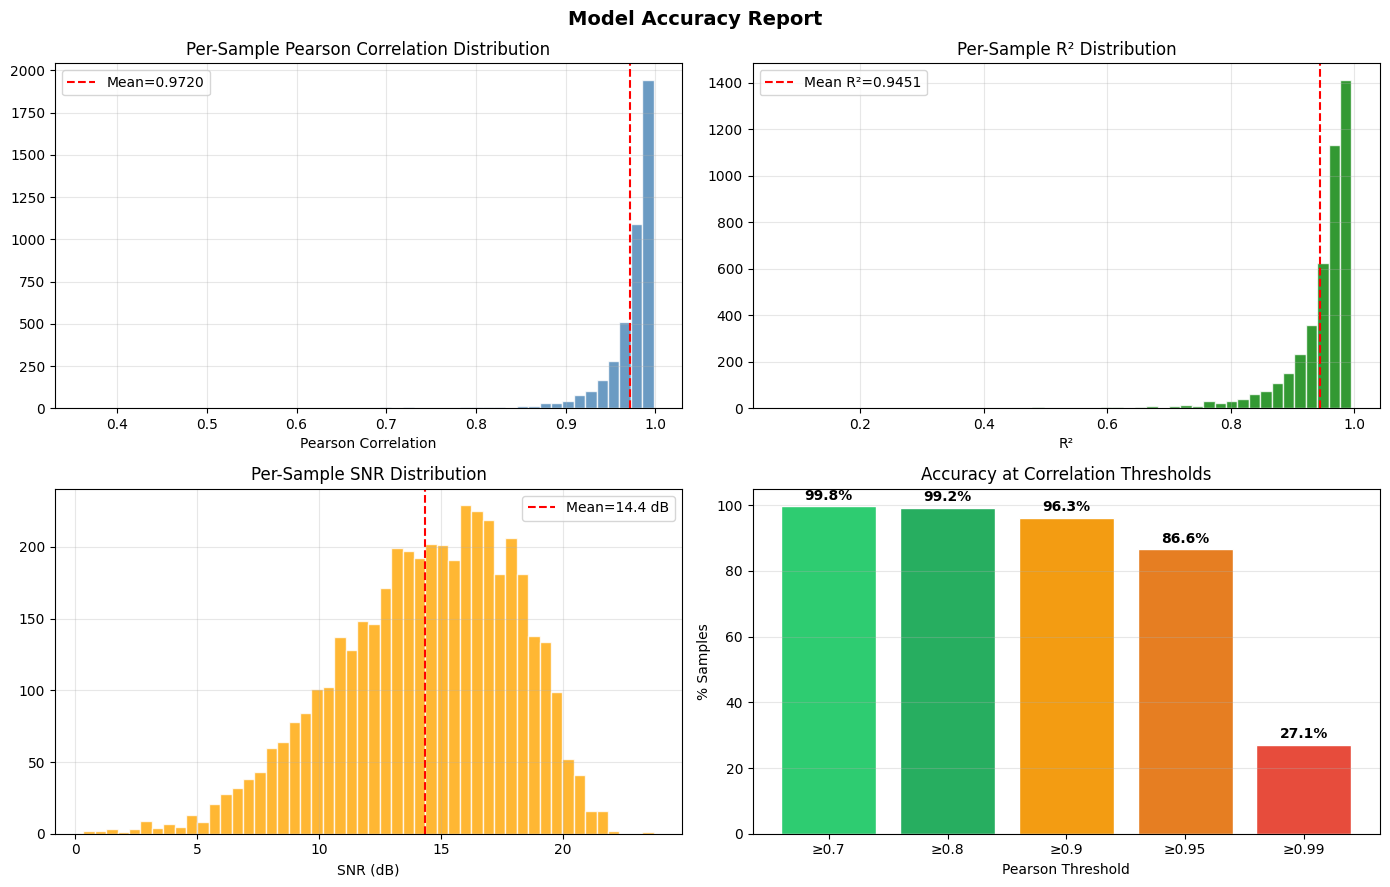

In [10]:
# Cell 9b: Comprehensive Accuracy & Metrics Report

from scipy.stats import pearsonr
from scipy import signal as scipy_signal

pred_np = preds.detach().cpu().numpy()
target_np = targets.detach().cpu().numpy()
N = pred_np.shape[0]

# ── 1. Per-sample Pearson Correlation ──
per_sample_corr = np.array([pearsonr(pred_np[i], target_np[i])[0] for i in range(N)])

# ── 2. R² (Coefficient of Determination) ──
ss_res = np.sum((target_np - pred_np) ** 2, axis=1)
ss_tot = np.sum((target_np - target_np.mean(axis=1, keepdims=True)) ** 2, axis=1)
per_sample_r2 = 1 - ss_res / (ss_tot + 1e-8)

# ── 3. Per-sample RMSE and MAE ──
per_sample_rmse = np.sqrt(np.mean((pred_np - target_np) ** 2, axis=1))
per_sample_mae = np.mean(np.abs(pred_np - target_np), axis=1)

# ── 4. Signal-to-Noise Ratio (SNR) ──
signal_power = np.mean(target_np ** 2, axis=1)
noise_power = np.mean((target_np - pred_np) ** 2, axis=1)
per_sample_snr = 10 * np.log10(signal_power / (noise_power + 1e-8))

# ── 5. Correlation-based "Accuracy" at thresholds ──
thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]
accuracy_at_thresh = {t: np.mean(per_sample_corr >= t) * 100 for t in thresholds}

# ── 6. R-peak Detection Accuracy ──
def r_peak_accuracy(pred_sig, target_sig, fs=500, tolerance_ms=50):
    """% of target R-peaks matched within tolerance_ms by a predicted peak."""
    tol_samples = int(tolerance_ms / 1000 * fs)
    pred_peaks, _ = scipy_signal.find_peaks(pred_sig, distance=250, prominence=0.5)
    tgt_peaks, _ = scipy_signal.find_peaks(target_sig, distance=250, prominence=0.5)
    if len(tgt_peaks) == 0:
        return np.nan, 0, 0
    matched = 0
    for tp in tgt_peaks:
        if len(pred_peaks) > 0:
            nearest = pred_peaks[np.argmin(np.abs(pred_peaks - tp))]
            if abs(nearest - tp) <= tol_samples:
                matched += 1
    return matched / len(tgt_peaks) * 100, matched, len(tgt_peaks)

rpeak_accs = []
total_matched = total_peaks = 0
for i in range(N):
    acc, m, t = r_peak_accuracy(pred_np[i], target_np[i])
    if not np.isnan(acc):
        rpeak_accs.append(acc)
        total_matched += m
        total_peaks += t
rpeak_accs = np.array(rpeak_accs)

# ════════════════════════════════════════════
# PRINT RESULTS
# ════════════════════════════════════════════
print("=" * 60)
print("COMPREHENSIVE ACCURACY REPORT")
print(f"Evaluated on {N} validation samples")
print("=" * 60)

print(f"\n{'─'*40}")
print("1. SIGNAL RECONSTRUCTION QUALITY")
print(f"{'─'*40}")
print(f"  Mean Pearson Correlation:  {np.mean(per_sample_corr):.4f} ± {np.std(per_sample_corr):.4f}")
print(f"  Median Pearson Corr:       {np.median(per_sample_corr):.4f}")
print(f"  Mean R² Score:             {np.mean(per_sample_r2):.4f} ± {np.std(per_sample_r2):.4f}")
print(f"  Mean RMSE:                 {np.mean(per_sample_rmse):.4f} ± {np.std(per_sample_rmse):.4f}")
print(f"  Mean MAE:                  {np.mean(per_sample_mae):.4f} ± {np.std(per_sample_mae):.4f}")
print(f"  Mean SNR:                  {np.mean(per_sample_snr):.1f} ± {np.std(per_sample_snr):.1f} dB")

print(f"\n{'─'*40}")
print("2. ACCURACY AT CORRELATION THRESHOLDS")
print(f"{'─'*40}")
for t, acc in accuracy_at_thresh.items():
    bar = "█" * int(acc / 2) + "░" * (50 - int(acc / 2))
    print(f"  Corr ≥ {t:.2f}: {bar} {acc:.1f}%")

print(f"\n{'─'*40}")
print("3. R-PEAK DETECTION ACCURACY (±50ms)")
print(f"{'─'*40}")
print(f"  Overall R-peak Accuracy:   {total_matched}/{total_peaks} = {total_matched/total_peaks*100:.1f}%")
print(f"  Mean per-sample Accuracy:  {np.mean(rpeak_accs):.1f}% ± {np.std(rpeak_accs):.1f}%")
print(f"  Median per-sample Acc:     {np.median(rpeak_accs):.1f}%")
print(f"  Samples with 100% R-peak:  {np.mean(rpeak_accs == 100)*100:.1f}%")

print(f"\n{'─'*40}")
print("4. WORST / BEST CASE ANALYSIS")
print(f"{'─'*40}")
print(f"  Best  Pearson: {np.max(per_sample_corr):.4f} (sample {np.argmax(per_sample_corr)})")
print(f"  Worst Pearson: {np.min(per_sample_corr):.4f} (sample {np.argmin(per_sample_corr)})")
print(f"  Best  SNR:     {np.max(per_sample_snr):.1f} dB")
print(f"  Worst SNR:     {np.min(per_sample_snr):.1f} dB")
print(f"  5th percentile Pearson:    {np.percentile(per_sample_corr, 5):.4f}")
print(f"  95th percentile Pearson:   {np.percentile(per_sample_corr, 95):.4f}")
print("=" * 60)

# ── Visualization ──
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Correlation distribution
axes[0, 0].hist(per_sample_corr, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0, 0].axvline(np.mean(per_sample_corr), color='red', linestyle='--', label=f'Mean={np.mean(per_sample_corr):.4f}')
axes[0, 0].set_title('Per-Sample Pearson Correlation Distribution')
axes[0, 0].set_xlabel('Pearson Correlation'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# R² distribution
axes[0, 1].hist(per_sample_r2, bins=50, color='green', edgecolor='white', alpha=0.8)
axes[0, 1].axvline(np.mean(per_sample_r2), color='red', linestyle='--', label=f'Mean R²={np.mean(per_sample_r2):.4f}')
axes[0, 1].set_title('Per-Sample R² Distribution')
axes[0, 1].set_xlabel('R²'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

# SNR distribution
axes[1, 0].hist(per_sample_snr, bins=50, color='orange', edgecolor='white', alpha=0.8)
axes[1, 0].axvline(np.mean(per_sample_snr), color='red', linestyle='--', label=f'Mean={np.mean(per_sample_snr):.1f} dB')
axes[1, 0].set_title('Per-Sample SNR Distribution')
axes[1, 0].set_xlabel('SNR (dB)'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)

# Accuracy at thresholds bar chart
thresh_labels = [f'≥{t}' for t in thresholds]
thresh_vals = [accuracy_at_thresh[t] for t in thresholds]
bars = axes[1, 1].bar(thresh_labels, thresh_vals, color=['#2ecc71', '#27ae60', '#f39c12', '#e67e22', '#e74c3c'],
                       edgecolor='white')
for bar, val in zip(bars, thresh_vals):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
axes[1, 1].set_title('Accuracy at Correlation Thresholds')
axes[1, 1].set_xlabel('Pearson Threshold'); axes[1, 1].set_ylabel('% Samples')
axes[1, 1].set_ylim(0, 105); axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Accuracy Report', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'accuracy_report.png'), dpi=150, bbox_inches='tight')
plt.show()

In [1]:
# Cell 10: Visual comparison — predicted vs ground truth

plot_comparison(preds, targets, num_samples=6, 
                save_path=os.path.join(CONFIG['checkpoint_dir'], 'final_comparison.png'))

NameError: name 'plot_comparison' is not defined

## 8. Export Model for Inference

In [ ]:
# Cell 11: Save lightweight inference-ready model

export_path = os.path.join(CONFIG['checkpoint_dir'], 'ecg_model_final.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'signal_length': CONFIG['signal_length'],
    'image_size': CONFIG['image_size'],
    'config': {k: str(v) for k, v in CONFIG.items()},
}, export_path)

size_mb = os.path.getsize(export_path) / (1024 * 1024)
print(f"Model saved to {export_path} ({size_mb:.1f} MB)")
print("Ready for inference pipeline!")